<a href="https://colab.research.google.com/github/adrianvalentim/gamify_life_old/blob/main/EP2_MAC0209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="5"> <a href="https://uspdigital.usp.br/jupiterweb/obterDisciplina?sgldis=MAC0209"> EP2 de MAC0209 - Modelagem e Simulação</a> </font>

Arthur Antunes Longo: 15498417 (IME-USP)

Adrian Valentim: 12645801 (IME-USP)

Nome e NUSP do Estudante 3 (IME-USP)

***
<font size="5"> Mobilidade Pedestre </font>
***

# Setup

In [1]:
!pip install sideseeing-tools

import math
import matplotlib.pyplot as pyplot
import pandas as pd
import numpy as np
import glob
import datetime
import os
import sideseeing_tools
import glob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: moviepy
    Found existing installation: moviepy 1.0.3
    Uninstalling moviepy-1.0.3:
      Successfully uninstalled moviepy-1.0.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lib

In [3]:
# lib aqui


# edite seu path abaixo:
def myPath():
  workDir = '/content/drive/MyDrive/Colab_Notebooks/EP2-MAC0209/EP2_EXPERIMENTOS/'
  return(workDir)

def demoWorkDir():
  # usa o ponto de montagem do google drive para  ler e salvar dados
  wd = myPath()
  csvFile = wd + 'MU-RETA1/sensors.three.csv'

  df = pd.read_csv(csvFile, sep = ';')
  print(df.to_string())

demoWorkDir()


                                                             timestamp_nano,datetime_utc,name,axis_x,axis_y,axis_z,accuracy
0         15602555302250,2025-05-21T16:09:18.902Z,lsm6dso LSM6DSO Accelerometer Non-wakeup,0.020937199,7.813164,3.0729825,3
1           15602576459281,2025-05-21T16:09:18.924Z,lsm6dso LSM6DSO Accelerometer Non-wakeup,-0.5515456,7.7742805,3.03051,3
2         15602545268552,2025-05-21T16:09:18.893Z,lsm6dso LSM6DSO Gyroscope Non-wakeup,0.15134175,-0.37949973,0.083688475,3
3         15602597616365,2025-05-21T16:09:18.945Z,lsm6dso LSM6DSO Accelerometer Non-wakeup,-0.12203395,8.979067,2.8031917,3
4           15602618773761,2025-05-21T16:09:18.966Z,lsm6dso LSM6DSO Accelerometer Non-wakeup,0.8105687,9.078369,2.6715865,3
5          15602639930792,2025-05-21T16:09:18.987Z,lsm6dso LSM6DSO Accelerometer Non-wakeup,0.74596244,7.487142,2.3353949,3
6          15602661088031,2025-05-21T16:09:19.008Z,lsm6dso LSM6DSO Accelerometer Non-wakeup,0.92183495,8.169695,2.4119651,3
7       

# Carregando arquivos

In [ ]:
def load_sensor_data(csv_path):
    try:
        df = pd.read_csv(csv_path)
        df['datetime'] = pd.to_datetime(df['datetime_utc'])
        df = df.sort_values('timestamp_nano').reset_index(drop=True)
        return df

    except Exception as e:
        print(f"Erro ao carregar {csv_path}: {e}")
        return None

def filter_accelerometer_data(df):
    accel_keywords = ['Accelerometer']
    accel_df = df[df['name'].str.contains('|'.join(accel_keywords), case=False, na=False)].copy()
    return accel_df

def load_experiment_data(folder_path):
    csv_path = os.path.join(folder_path, 'sensors.three.csv')

    if not os.path.exists(csv_path):
        print(f"sensors.three.csv não encontrado em {folder_path}")
        return None, None

    df = load_sensor_data(csv_path)
    if df is None:
        return None, None

    accel_df = filter_accelerometer_data(df)

    if accel_df.empty:
        print(f"Nenhum dado de acelerômetro encontrado em {folder_path}")
        return None, None

    print(f"Encontrados {len(accel_df)} pontos de dados do acelerômetro")

    return df, accel_df


## Funções para lidar com tempo


In [ ]:
def converte_para_segundos(df):
    """Prepara dados de tempo convertendo timestamps para segundos."""
    df['time_seconds'] = (df['timestamp_nano'] - df['timestamp_nano'].iloc[0]) / 1e9
    #dt = np.diff(df['time_seconds'].values)
    return df

def valores_de_tempo_em_segundos(df):
    dt = np.diff(df['time_seconds'].values)
    return dt

# Encontrando spikes no z (marcações de tempo)

In [4]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/EP2-MAC0209/EP2_EXPERIMENTOS'

In [5]:
NUM_SPIKES = 3
MIN_SPIKE_SEPARATION = 0.9 # segundos
OUTPUT_FILENAME = "results.txt"
ACCELEROMETER_KEYWORDS = ['Accelerometer', 'linear_acceleration']

In [6]:
def detect_spikes(accel_df, axis_name='axis_y', num_spikes_to_find=NUM_SPIKES, min_separation_seconds=MIN_SPIKE_SEPARATION):
    if accel_df.empty or axis_name not in accel_df.columns or 'time_seconds' not in accel_df.columns: return []
    abs_accel_series = accel_df[axis_name].abs()
    sorted_indices_by_strength = abs_accel_series.sort_values(ascending=False).index
    selected_spike_indices = []
    selected_spike_times = []
    for current_spike_index in sorted_indices_by_strength:
        current_spike_time = accel_df.loc[current_spike_index, 'time_seconds']
        is_separated = True
        for pst in selected_spike_times:
            if abs(current_spike_time - pst) < min_separation_seconds: is_separated = False; break
        if is_separated:
            selected_spike_indices.append(current_spike_index)
            selected_spike_times.append(current_spike_time)
            if len(selected_spike_indices) == num_spikes_to_find: break
    return sorted(selected_spike_indices)

In [7]:
def find_folders(PATH):
    """procura as pastas dos experimentos dentro de PATH"""
    # Get all items in EXPERIMENTOS path
    all_items = glob.glob(os.path.join(PATH, "*"))
    # Filter for directories only
    experiment_folders = [item for item in all_items if os.path.isdir(item)]
    experiment_folders.sort()
    if not experiment_folders:
        print(f"Sem pastas em {PATH}.")
    else:
        print(f"Encontrei {len(experiment_folders)} pastas em {PATH}.")
    return experiment_folders

def load_sensor_data(csv_path):
    try:
        df = pd.read_csv(csv_path)
        df['datetime'] = pd.to_datetime(df['datetime_utc'])
        df = df.sort_values('timestamp_nano').reset_index(drop=True)
        df['time_seconds'] = (df['timestamp_nano'] - df['timestamp_nano'].iloc[0]) / 1e9
        return df
    except Exception as e:
        print(f"Erro ao carregar {csv_path}: {e}")
        return None

def filter_accelerometer_data(df):
    if df is None: return None
    accel_df = df[df['name'].str.contains('|'.join(ACCELEROMETER_KEYWORDS), case=False, na=False)].copy()
    if accel_df.empty: print("  No accelerometer data found after filtering.")
    return accel_df


def get_segment_boundary_indices(accel_df_indices, spike_indices):
    start_index = accel_df_indices[0]
    end_index = accel_df_indices[-1]
    boundaries = [start_index] + spike_indices + [end_index]
    unique_boundaries = sorted(list(set(boundaries)))
    return unique_boundaries if len(unique_boundaries) >= 2 else [start_index, end_index]

def integrar_aceleracao(ax, ay, az, dt_values):
    vx, vy, vz = np.zeros(len(ax)), np.zeros(len(ay)), np.zeros(len(az))
    for i in range(1, len(ax)):
        if i - 1 < len(dt_values):
            dt = dt_values[i-1]
            vx[i] = vx[i-1] + (ax[i-1] + ax[i]) * dt / 2
            vy[i] = vy[i-1] + (ay[i-1] + ay[i]) * dt / 2
            vz[i] = vz[i-1] + (az[i-1] + az[i]) * dt / 2
    return vx, vy, vz

def calculate_overall_velocity(accel_df):
    if accel_df.empty or len(accel_df) < 2: return None, None, None, None
    time_seconds = accel_df['time_seconds'].values
    dt_values = np.diff(time_seconds)
    ax, ay, az = accel_df['axis_x'].values, accel_df['axis_y'].values, accel_df['axis_z'].values
    vx, vy, vz = integrar_aceleracao(ax, ay, az, dt_values)
    v_magnitude_xz = np.sqrt(vx**2 + vz**2) # XZ Plane
    return vx, vy, vz, v_magnitude_xz

def calculate_overall_averages(accel_df, vx, vy, vz, v_magnitude_xz):
    if accel_df.empty: return {k: 0 for k in ['avg_accel_x', 'avg_accel_y', 'avg_accel_z', 'avg_accel_mag_xz', 'avg_velo_x', 'avg_velo_y', 'avg_velo_z', 'avg_velo_xz_mag']}
    avg_ax = np.mean(accel_df['axis_x']); avg_ay = np.mean(accel_df['axis_y']); avg_az = np.mean(accel_df['axis_z'])
    avg_accel_mag_xz = np.mean(np.sqrt(accel_df['axis_x']**2 + accel_df['axis_z']**2)) # XZ Plane
    avg_vx = np.mean(vx) if vx is not None else 0
    avg_vy = np.mean(vy) if vy is not None else 0
    avg_vz = np.mean(vz) if vz is not None else 0
    avg_velo_xz_mag = np.mean(v_magnitude_xz) if v_magnitude_xz is not None else 0
    return {
        'avg_accel_x': avg_ax, 'avg_accel_y': avg_ay, 'avg_accel_z': avg_az, 'avg_accel_mag_xz': avg_accel_mag_xz,
        'avg_velo_x': avg_vx, 'avg_velo_y': avg_vy, 'avg_velo_z': avg_vz, 'avg_velo_xz_mag': avg_velo_xz_mag
    }

def analiza_experimento(folder_path):
    experiment_name = os.path.basename(folder_path)
    print(f"Processing experiment: {experiment_name}")
    full_df = load_sensor_data(os.path.join(folder_path, 'sensors.three.csv'))
    if full_df is None: return None
    accel_df = filter_accelerometer_data(full_df)
    if accel_df is None or accel_df.empty: return None
    accel_df = accel_df.reset_index(drop=True)

    # Get spike times for segment definition
    spike_indices = detect_spikes(accel_df)
    boundary_indices = get_segment_boundary_indices(accel_df.index, spike_indices)
    segment_boundary_times = [accel_df.loc[idx, 'time_seconds'] for idx in boundary_indices]

    print(f"  Y-Spike for {experiment_name}: {[f'{t:.2f}s' for t in segment_boundary_times]}")


    vx, vy, vz, v_mag_xz = calculate_overall_velocity(accel_df)
    if vx is None:
        raise ValueError(f"Could not calculate overall velocity for {experiment_name}.")
        overall_averages = {k: 'N/A' for k in ['avg_accel_x', 'avg_accel_y', 'avg_accel_z', 'avg_accel_mag_xz', 'avg_velo_x', 'avg_velo_y', 'avg_velo_z', 'avg_velo_xz_mag']}
    else:
        overall_averages = calculate_overall_averages(accel_df, vx, vy, vz, v_mag_xz)

    return {
        'experiment_name': experiment_name,
        'segment_boundary_times': segment_boundary_times,
        'overall_averages': overall_averages
    }


In [8]:
def main():
    all_experiment_folders = find_folders(PATH)
    if not all_experiment_folders: return

    all_results = []
    for folder in all_experiment_folders:
        res = analiza_experimento(folder)
        if res: all_results.append(res)

    if not all_results:
        print("No data processed across all experiments.")
        with open(OUTPUT_FILENAME, 'w') as f: f.write("Experiment Analysis - Segment Times & Overall XZ Averages\nNo data processed.")
        return

    with open(OUTPUT_FILENAME, 'w') as f:
        f.write("ANÁLISE DOS EXPERIMENTOS\n")
        for exp_res in sorted(all_results, key=lambda x: x['experiment_name']):
            f.write(f"------\nEXPERIMENTO: {exp_res['experiment_name']}\n")

            boundary_times = exp_res['segment_boundary_times']

            for i in range(4):
                if i < len(boundary_times) - 1:
                    start_t = boundary_times[i]
                    end_t = boundary_times[i+1]
                    f.write(f"T{i}: Start: {start_t:.2f}s, End: {end_t:.2f}s\n")
                else:
                    f.write(f"T{i}: N/A (problema na detecção de spike)\n")
            f.write("\n")

            avgs = exp_res['overall_averages']

            def fmt(val): return f"{val:.3f}" if isinstance(val, (int, float)) else str(val)

            f.write(f"Avg. Accel (X, Y, Z): {fmt(avgs['avg_accel_x'])}, {fmt(avgs['avg_accel_y'])}, {fmt(avgs['avg_accel_z'])} m/s^2\n")
            f.write(f"Avg. Accel Mag (XZ Plane): {fmt(avgs['avg_accel_mag_xz'])} m/s^2\n")
            f.write(f"Avg. Velo (X, Y, Z): {fmt(avgs['avg_velo_x'])}, {fmt(avgs['avg_velo_y'])}, {fmt(avgs['avg_velo_z'])} m/s\n")
            f.write(f"Avg. Velo Mag (XZ Plane): {fmt(avgs['avg_velo_xz_mag'])} m/s\n")
            f.write("-------\n\n")

    print(f"\n YES! Salvamos os resultados em {OUTPUT_FILENAME}")

In [9]:
main()

Encontrei 20 pastas em /content/drive/MyDrive/Colab_Notebooks/EP2-MAC0209/EP2_EXPERIMENTOS.
Processing experiment: MU-RETA1
  Y-Spike for MU-RETA1: ['0.01s', '12.98s', '18.35s', '23.68s', '24.41s']
Processing experiment: MU-RETA2
  Y-Spike for MU-RETA2: ['0.01s', '6.31s', '10.87s', '17.24s', '23.69s']
Processing experiment: MU-RETA3
  Y-Spike for MU-RETA3: ['0.00s', '12.16s', '17.68s', '22.14s', '22.67s']
Processing experiment: MU-RETA4
  Y-Spike for MU-RETA4: ['0.00s', '0.87s', '6.46s', '17.00s', '23.13s']
Processing experiment: MU-RETA5
  Y-Spike for MU-RETA5: ['0.00s', '6.58s', '12.53s', '18.38s', '24.75s']
Processing experiment: MU-ZIGZAG1
  Y-Spike for MU-ZIGZAG1: ['0.02s', '6.03s', '12.71s', '19.14s', '26.27s']
Processing experiment: MU-ZIGZAG2
  Y-Spike for MU-ZIGZAG2: ['0.03s', '7.30s', '12.46s', '17.69s', '23.75s']
Processing experiment: MU-ZIGZAG3
  Y-Spike for MU-ZIGZAG3: ['0.00s', '7.06s', '12.73s', '17.77s', '23.77s']
Processing experiment: MU-ZIGZAG4
  Y-Spike for MU-ZIGZ

In [ ]:
def detect_z_spikes(accel_df, threshold, min_separation_seconds, max_spikes=None):
    """Detecta picos na aceleração do eixo Z e retorna os índices dos limites dos segmentos."""
    if accel_df.empty:
        print("Acelerômetro df vazio, não é possível detectar picos.")
        return []
    if 'axis_z' not in accel_df.columns:
        print("Coluna 'axis_z' faltando no DataFrame do acelerômetro para detecção de picos.")
        return []
    if 'time_seconds' not in accel_df.columns:
        print("Coluna 'time_seconds' faltando no DataFrame do acelerômetro para detecção de picos.")
        return []

    potential_spike_candidates = accel_df.loc[accel_df['axis_z'].abs() > threshold].copy()

    if potential_spike_candidates.empty:
        raise ValueError("Nenhum pico encontrado acima do limiar marcando o tempo")


    preliminary_spike_indices = []
    last_spike_time = -float('inf')


    # como cada vez que a gente balançou o celular gerou várias marcações de spike diferentes,
    # precisamos deixar apesar a primeira marcação
    for index, row in potential_spike_candidates.iterrows():
        current_time = row['time_seconds']
        if current_time - last_spike_time > min_separation_seconds:
            preliminary_spike_indices.append(index)
            last_spike_time = current_time


    if max_spikes is not None and len(preliminary_spike_indices) > max_spikes:
        preliminary_spikes_df = accel_df.loc[preliminary_spike_indices].copy()
        preliminary_spikes_df['abs_axis_y'] = preliminary_spikes_df['axis_y'].abs()
        strongest_spike_indices = preliminary_spikes_df.nlargest(max_spikes, 'abs_axis_y').index.tolist()
        actual_spike_indices = sorted(strongest_spike_indices, key=lambda idx: accel_df.loc[idx, 'time_seconds'])
    else:
        actual_spike_indices = preliminary_spike_indices

    segment_boundaries = [accel_df.index[0]]

    segment_boundaries.extend(actual_spike_indices)
    if not actual_spike_indices or actual_spike_indices[-1] != accel_df.index[-1]:
        segment_boundaries.append(accel_df.index[-1])
    unique_segment_boundaries = sorted(list(set(segment_boundaries)))

    if len(unique_segment_boundaries) < 3:
        raise ValueError("Não foi possível definir segmentos")

    return unique_segment_boundaries


## FUNÇÕES ÚTEIS (para lidar com aceleração)

In [ ]:
def accel_components(df):
    """Extrai componentes de aceleração como arrays numpy."""
    ax = df['axis_x'].values
    ay = df['axis_y'].values
    az = df['axis_z'].values
    return ax, ay, az


def integrar_aceleracao(ax, ay, az, dt):
    """Integra aceleração para obter velocidade usando regra trapezoidal."""
    # Inicializa arrays de velocidade (assumindo velocidade inicial zero)
    vx = np.zeros(len(ax))
    vy = np.zeros(len(ay))
    vz = np.zeros(len(az))

    # Calcula velocidade por integração
    for i in range(1, len(ax)):
        vx[i] = vx[i-1] + (ax[i-1] + ax[i]) * dt[i-1] / 2
        vy[i] = vy[i-1] + (ay[i-1] + ay[i]) * dt[i-1] / 2
        vz[i] = vz[i-1] + (az[i-1] + az[i]) * dt[i-1] / 2

    return vx, vy, vz


def calculate_velocity_magnitude(vx, vy):
    """Calcula magnitude usando componentes X e Y."""
    return np.sqrt(vx**2 + vy**2)

def add_velocity_to_df(df, vx, vy, vz, v_magnitude):
    df['velocity_x'] = vx
    df['velocity_y'] = vy
    df['velocity_z'] = vz
    df['velocity_magnitude'] = v_magnitude
    return df

def velocity_from_accel(df):
    """Calcula velocidade integrando dados de aceleração."""
    if df.empty:
        return None, None, None, None

    dt = valores_de_tempo_em_segundos(df)
    ax, ay, az = accel_components(df)
    vx, vy, vz = integrar_aceleracao(ax, ay, az, dt)
    v_magnitude = calculate_velocity_magnitude(vx, vy)

    df = add_velocity_to_df(df, vx, vy, vz, v_magnitude)

    return df, vx, vy, vz

### Cálcula médias

In [ ]:
def calculate_average_velocities(velocity_df, skip_points):
    """Calcula velocidades médias dos componentes."""
    avg_velocity_x = np.mean(velocity_df['velocity_x'][skip_points:])
    avg_velocity_y = np.mean(velocity_df['velocity_y'][skip_points:])
    avg_velocity_z = np.mean(velocity_df['velocity_z'][skip_points:])
    avg_velocity_magnitude = np.mean(velocity_df['velocity_magnitude'][skip_points:])

    return {
        'x': avg_velocity_x,
        'y': avg_velocity_y,
        'z': avg_velocity_z,
        'magnitude': avg_velocity_magnitude
    }


def calculate_average_acceleration(velocity_df, skip_points=0):
    """Calcula componentes médias e magnitude da aceleração."""
    if velocity_df.empty or len(velocity_df) <= skip_points:
        return {'x': 0, 'y': 0, 'z': 0, 'magnitude': 0}

    avg_accel_x = np.mean(velocity_df['axis_x'][skip_points:])
    avg_accel_y = np.mean(velocity_df['axis_y'][skip_points:])
    avg_accel_z = np.mean(velocity_df['axis_z'][skip_points:])
    avg_accel_magnitude = np.mean(np.sqrt(velocity_df['axis_x'][skip_points:]**2 + velocity_df['axis_y'][skip_points:]**2 + velocity_df['axis_z'][skip_points:]**2))

    return {
        'x': avg_accel_x,
        'y': avg_accel_y,
        'z': avg_accel_z,
        'magnitude': avg_accel_magnitude
    }


## Processa resultados


In [ ]:
def create_experiment_results(experiment_name, duration, avg_velocities, avg_accelerations, velocity_df, interval):
    """Cria dicionário com resultados do experimento para um dado intervalo."""
    return {
        'experimento': experiment_name,
        'intervalo': interval,
        'duration_seconds': duration,
        'data_points': len(velocity_df),
        'avg_velocity_x': avg_velocities['x'],
        'avg_velocity_y': avg_velocities['y'],
        'avg_velocity_z': avg_velocities['z'],
        'avg_velocity_magnitude_xy': avg_velocities['magnitude'],
        'avg_accel_x': avg_accelerations['x'],
        'avg_accel_y': avg_accelerations['y'],
        'avg_accel_z': avg_accelerations['z'],
        'avg_accel_magnitude': avg_accelerations['magnitude'],
    }



def stats_do_experimento(velocity_df):
    """Calcula estatísticas do experimento."""
    experiment_duration = velocity_df['time_seconds'].iloc[-1] - velocity_df['time_seconds'].iloc[0]

    # Velocidades médias (excluindo valores iniciais zero)
    skip_points = min(10, len(velocity_df) // 10)  # Pula os primeiros 10 pontos ou 10% dos dados
    avg_velocities = calculate_average_velocities(velocity_df, skip_points)


    # Magnitude média da aceleração para referência
    avg_accelerations = calculate_average_acceleration(velocity_df)

    return experiment_duration, avg_velocities, avg_accelerations

In [ ]:
def processa_intervalo(accel_df_stage, experiment_name, tempo):
    """Processa um estágio específico de um experimento MU-RETA."""


    velocity_df, vx, vy, vz = velocity_from_accel(accel_df_stage)
    if velocity_df is None or velocity_df.empty:
        print(f"Não foi possível calcular a velocidade para o estágio {tempo} de {experiment_name}.")
        return None

    # Calcula estatísticas para o estágio
    duration, avg_velocities, avg_accelerations = stats_do_experimento(velocity_df)


    # Cria e retorna resultados para o estágio
    return create_experiment_results(experiment_name, duration, avg_velocities, avg_accelerations, velocity_df, tempo)

In [ ]:
def analyze_experiment(folder_path):
    """Analisa uma única pasta de experimento MU-RETA segmentando intervalos de tempo por picos em Z."""


    _, accel_df = load_experiment_data(folder_path)

    experiment_name = os.path.basename(folder_path)

    accel_df = converte_para_segundos(accel_df)

    # detecta picos na aceleração Z para definir os intervalos
    intervalos_tempo = detect_z_spikes(accel_df, SPIKE_THRESHOLD_Z_ABS, MIN_SPIKE_SEPARATION_SECONDS, MAX_SPIKES_TO_DETECT)

    resultados_por_intervalo = []
    num_intervalo = len(intervalos_tempo) - 1

    for i in range(num_intervalo):
        start_index = intervalos_tempo[i]
        end_index = intervalos_tempo[i+1]


        if i == num_intervalo - 1:
            accel_df_intervalo = accel_df.loc[start_index:end_index].copy()
        else:
            accel_df_intervalo = accel_df.loc[start_index:end_index-1].copy()


        if accel_df_intervalo.empty or len(accel_df_intervalo) < 2: # Precisa de pelo menos 2 pontos para diff em tempo
            print(f"Intervalo {i} de {experiment_name} tem dados insuficientes ({len(accel_df_intervalo)} pontos) entre índices {start_index} e {end_index}.")
            continue


        tempo = str(i)
        actual_end_index = end_index -1 if i < num_intervalo -1 else end_index
        print(f"Processando Tempo {tempo} (Índices {start_index} a {actual_end_index}, {len(accel_df_intervalo)} pontos) de {experiment_name}...")


        result = processa_intervalo(accel_df_intervalo, experiment_name, tempo)
        if result:
            resultados_por_intervalo.append(result)

    return resultados_por_intervalo



## Essa Analyze_Experiment está criando uma lista de dicionários
## cada dicionário da lista é criado pelo create_experiment_results

wd = myPath()
folder_path = wd + "MU-RETA1/"
results = analyze_experiment(folder_path)
print(results)

Encontrados 2444 pontos de dados do acelerômetro
Processando Tempo 0 (Índices 1 a 1286, 763 pontos) de ...
Processando Tempo 1 (Índices 1287 a 3908, 1551 pontos) de ...
Processando Tempo 2 (Índices 3909 a 3994, 51 pontos) de ...
Processando Tempo 3 (Índices 3995 a 4127, 79 pontos) de ...
[{'experimento': '', 'intervalo': '0', 'duration_seconds': np.float64(7.656879115), 'data_points': 763, 'avg_velocity_x': np.float64(3.1483125282625872), 'avg_velocity_y': np.float64(36.153908490862015), 'avg_velocity_z': np.float64(9.431103072734611), 'avg_velocity_magnitude_xy': np.float64(36.299140229483264), 'avg_accel_x': np.float64(0.8288927383262125), 'avg_accel_y': np.float64(8.943268717785058), 'avg_accel_z': np.float64(2.3862337518063694), 'avg_accel_magnitude': np.float64(11.010030782527755)}, {'experimento': '', 'intervalo': '1', 'duration_seconds': np.float64(15.441424427000001), 'data_points': 1551, 'avg_velocity_x': np.float64(8.26666882616751), 'avg_velocity_y': np.float64(71.7940433194

In [ ]:
def process_all_mu_reta(base_folder_path):
    all_items = os.listdir(base_folder_path)

    mu_reta_folders = [
        item for item in all_items
        if item.startswith("MU-RETA") and os.path.isdir(os.path.join(base_folder_path, item))
    ]

    for folder_name in mu_reta_folders:
        experiment_folder_path = os.path.join(base_folder_path, folder_name)

        experiment_results = analyze_experiment(experiment_folder_path)

        output_filename = f"{folder_name}_analysis_results.txt"

        with open(output_filename, 'w', encoding='utf-8') as f:
            f.write(f"Resultado do {folder_name}\n")
            f.write(f"Source folder: {experiment_folder_path}\n")
            f.write("=" * 40 + "\n\n")


            for i, result_item in enumerate(experiment_results):

                intervalo = result_item.get('i', f"t = {i} até t = {i+1}")
                f.write(f"--- Intervalo: {intervalo} ---\n")
                for key, value in result_item.items():
                    if key == 'velocity_data' and hasattr(value, 'shape'):
                        f.write(f"  {key}: DataFrame with {value.shape[0]} rows, {value.shape[1]} columns\n")
                    else:
                        f.write(f"  {key}: {value}\n")
                f.write("\n")

        print(f"Salvou resultado {folder_name} to {output_filename}")

In [ ]:
base_folder_path = myPath()
process_all_mu_reta(base_folder_path)

Encontrados 2444 pontos de dados do acelerômetro
Processando Tempo 0 (Índices 1 a 1286, 763 pontos) de MU-RETA1...
Processando Tempo 1 (Índices 1287 a 3908, 1551 pontos) de MU-RETA1...
Processando Tempo 2 (Índices 3909 a 3994, 51 pontos) de MU-RETA1...
Processando Tempo 3 (Índices 3995 a 4127, 79 pontos) de MU-RETA1...
Salvou resultado MU-RETA1 to MU-RETA1_analysis_results.txt
Encontrados 2370 pontos de dados do acelerômetro
Processando Tempo 0 (Índices 1 a 1822, 1081 pontos) de MU-RETA2...
Processando Tempo 1 (Índices 1823 a 1910, 51 pontos) de MU-RETA2...
Processando Tempo 2 (Índices 1911 a 3874, 1162 pontos) de MU-RETA2...
Processando Tempo 3 (Índices 3875 a 3999, 76 pontos) de MU-RETA2...
Salvou resultado MU-RETA2 to MU-RETA2_analysis_results.txt
Encontrados 2131 pontos de dados do acelerômetro
Processando Tempo 0 (Índices 0 a 1695, 1018 pontos) de MU-RETA3...
Processando Tempo 1 (Índices 1696 a 1786, 53 pontos) de MU-RETA3...
Processando Tempo 2 (Índices 1787 a 2632, 501 pontos) d

## Coleta SideSeeing


INFO. Loading data.
INFO. Done.


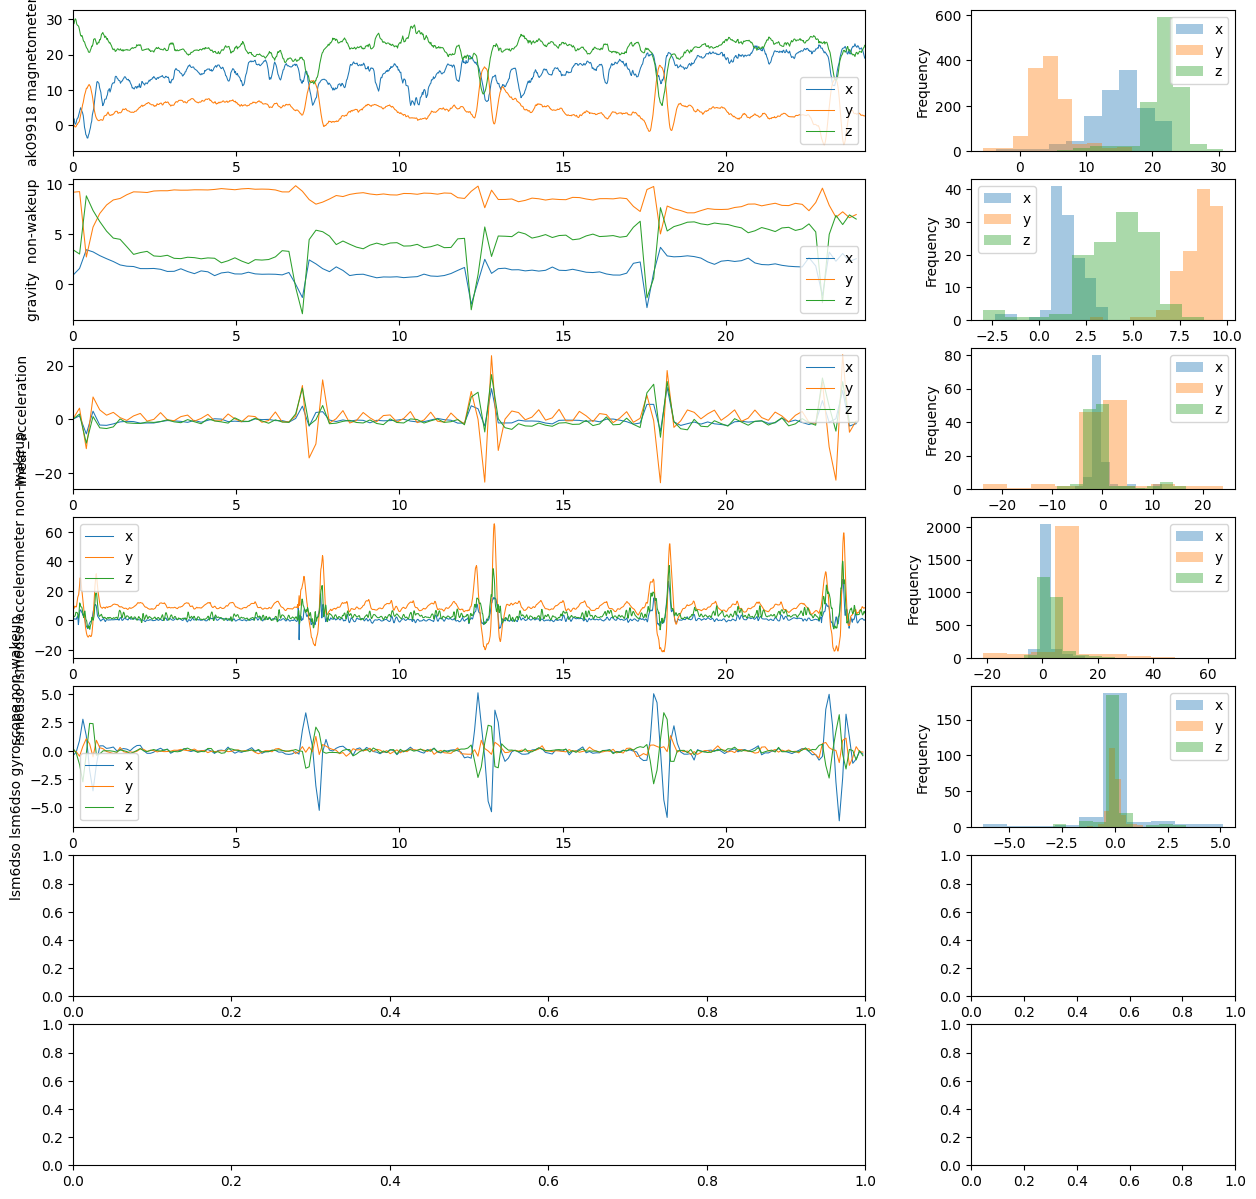

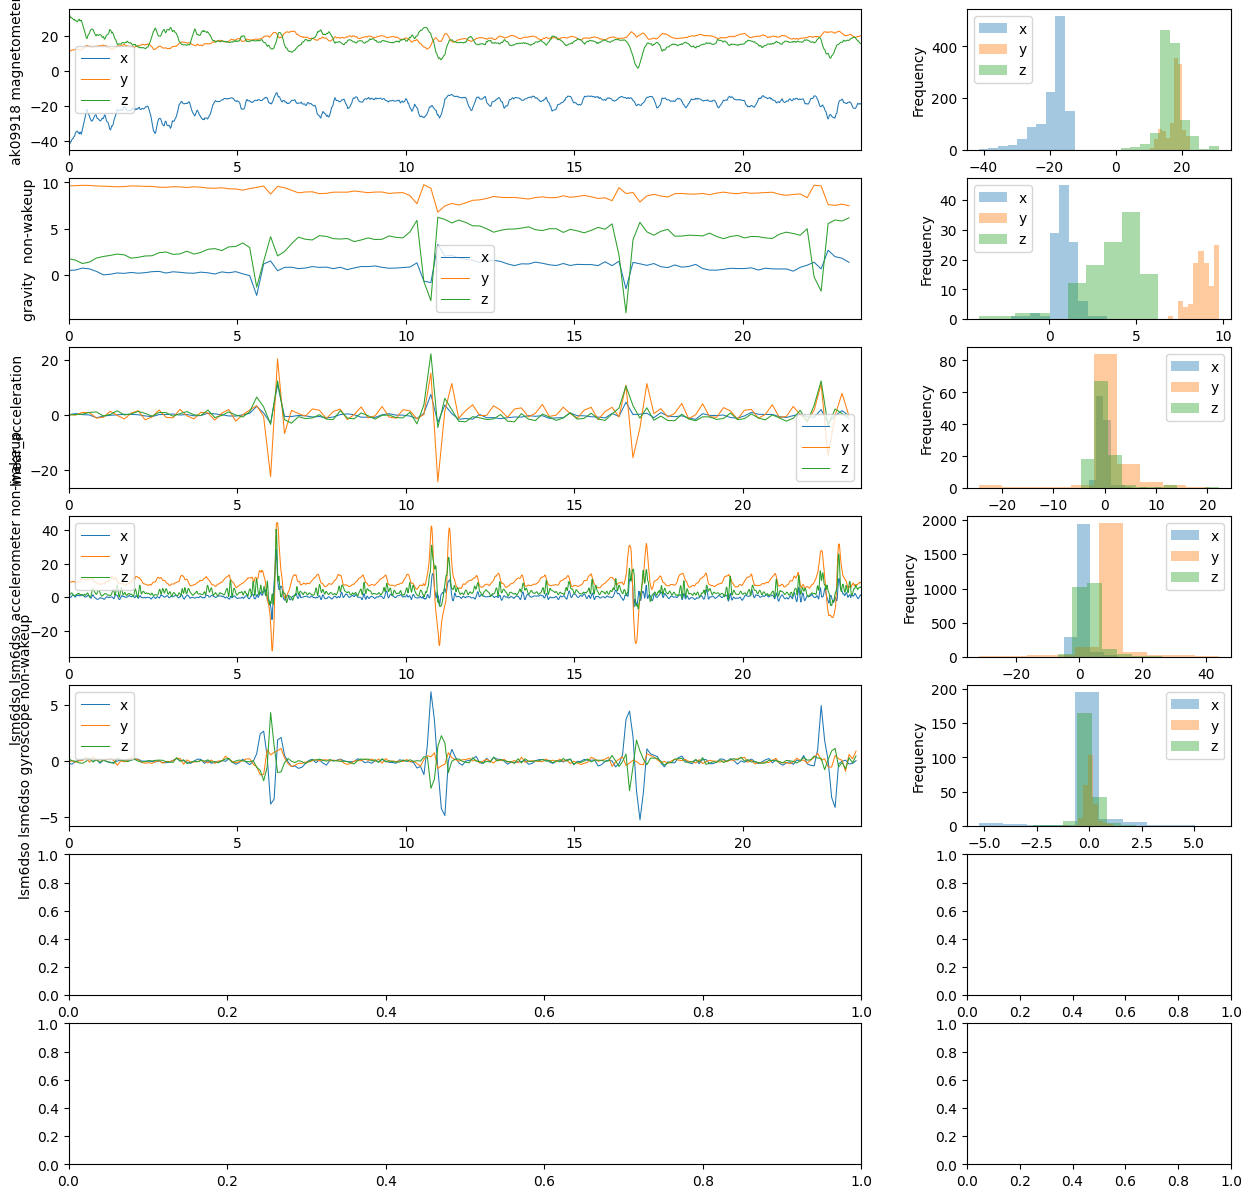

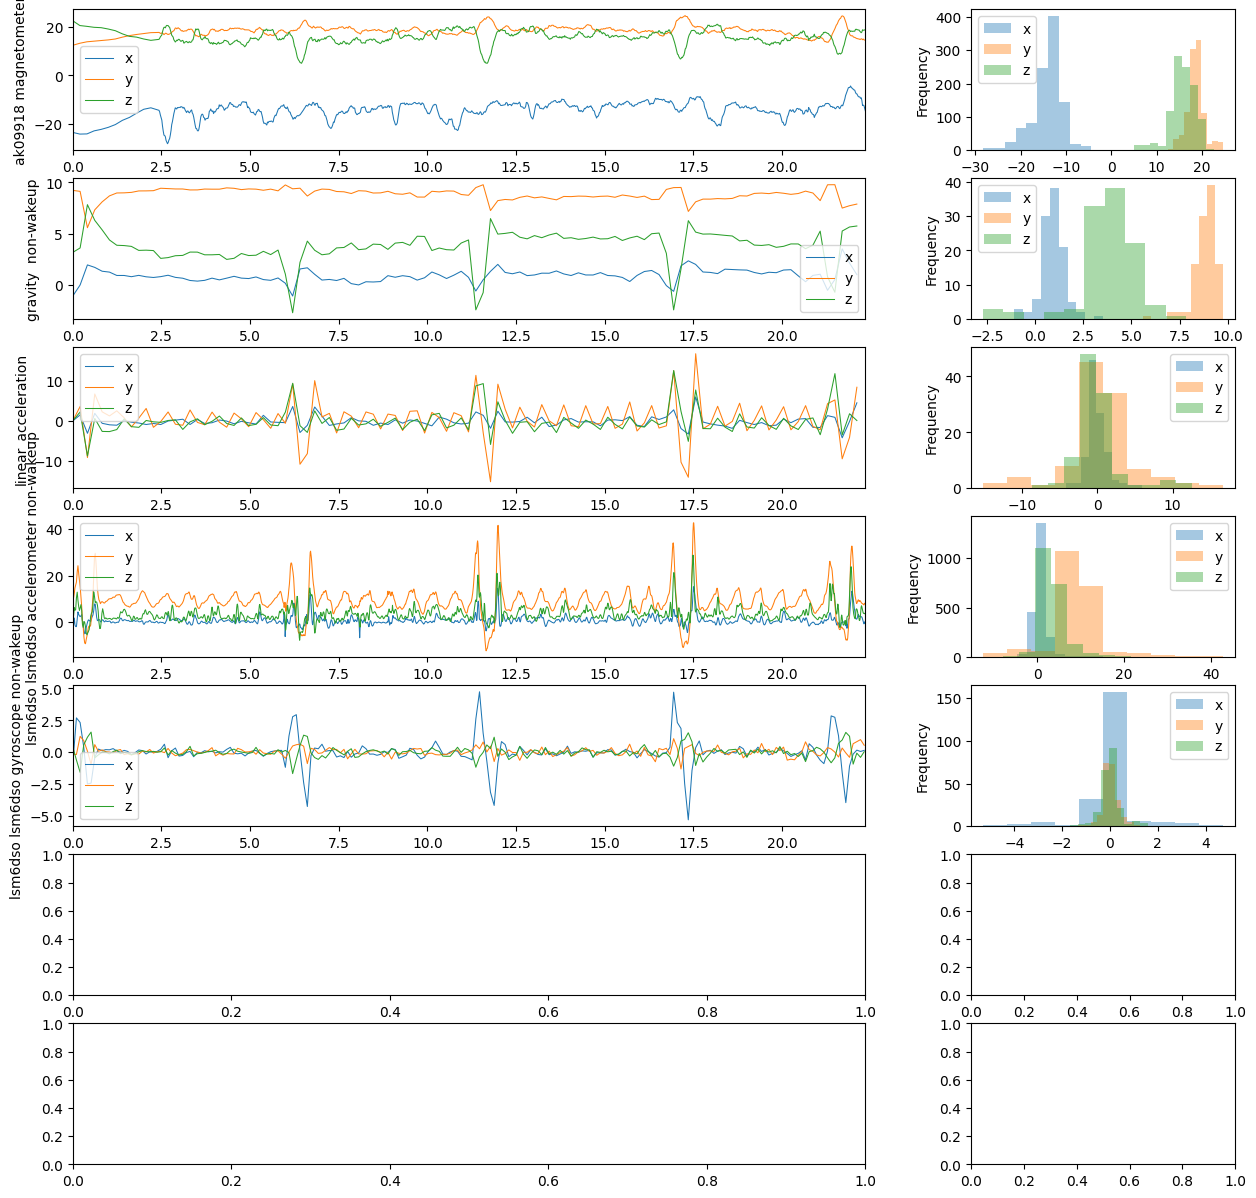

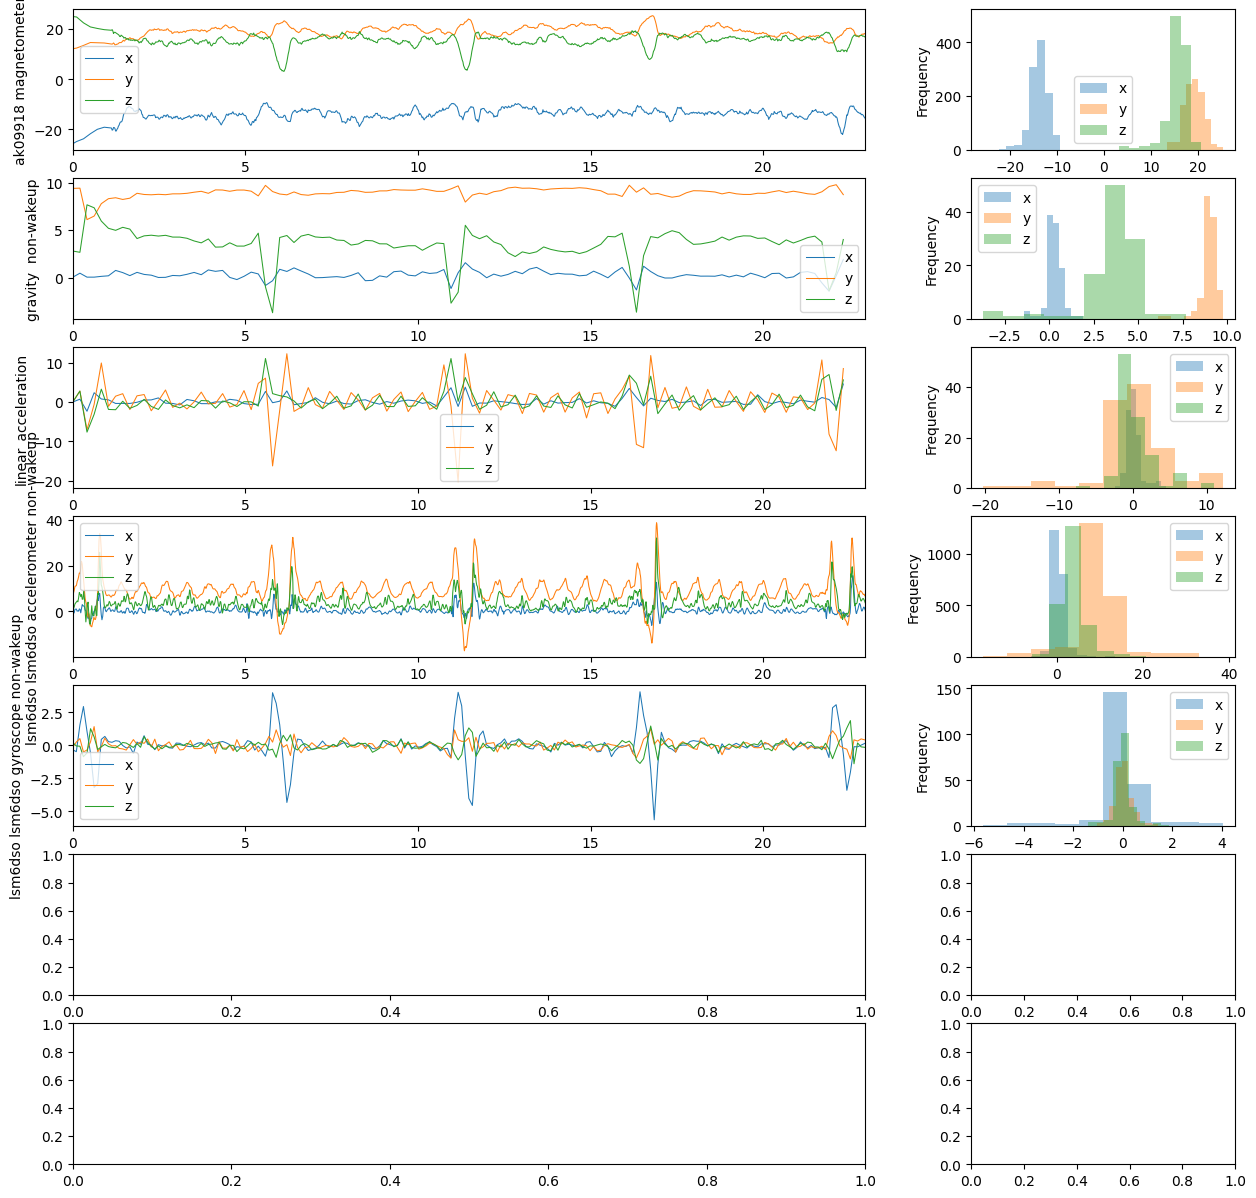

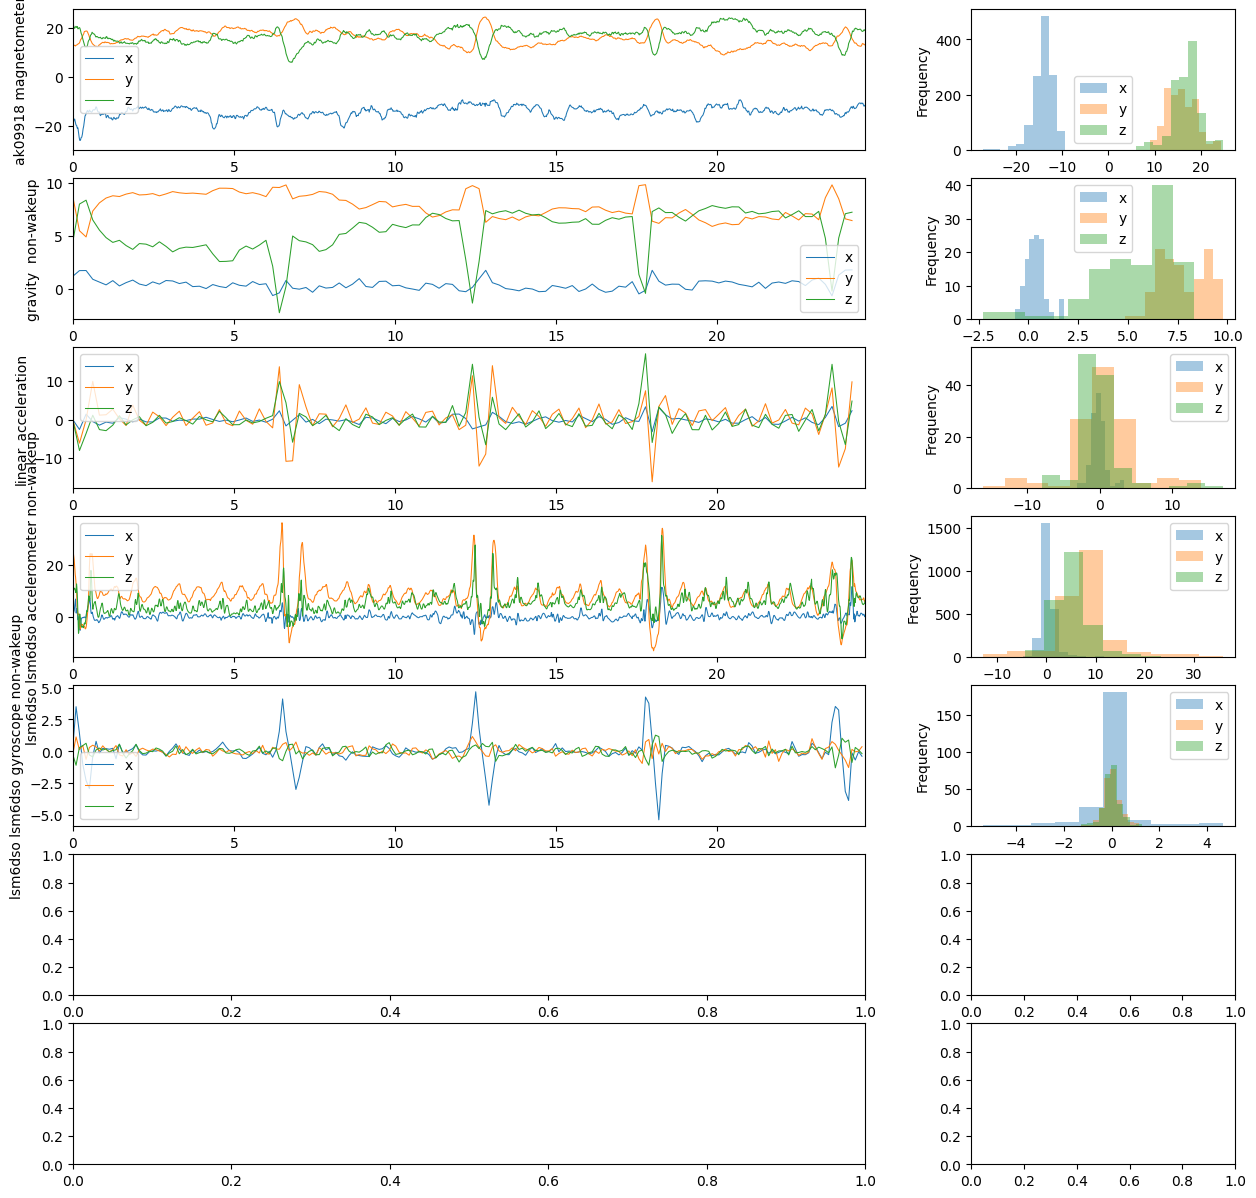

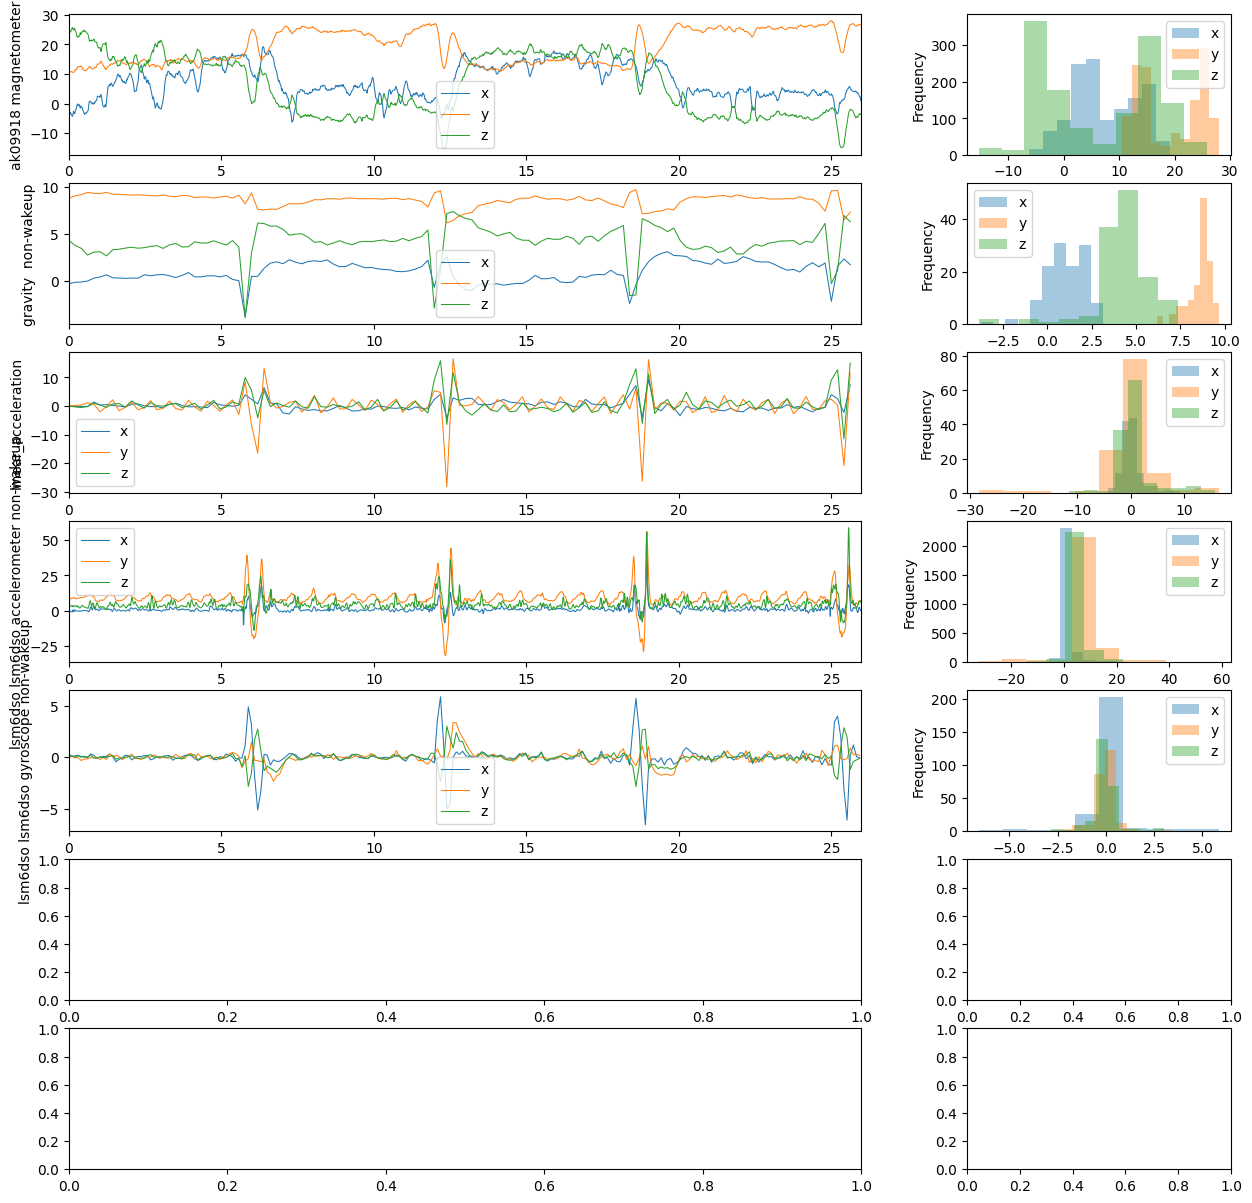

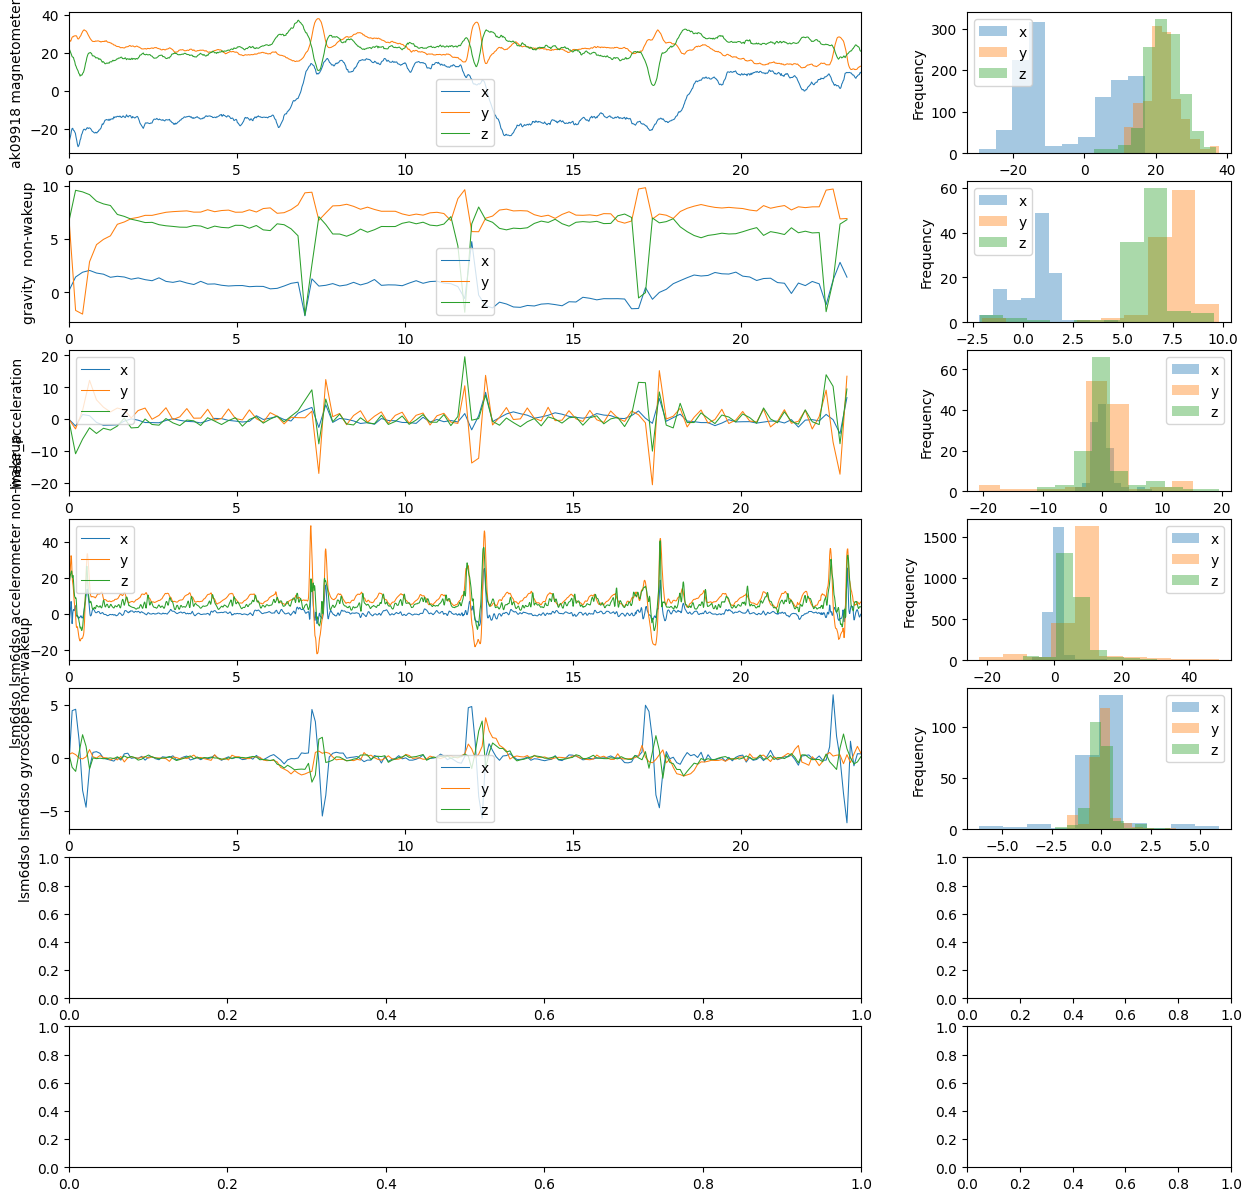

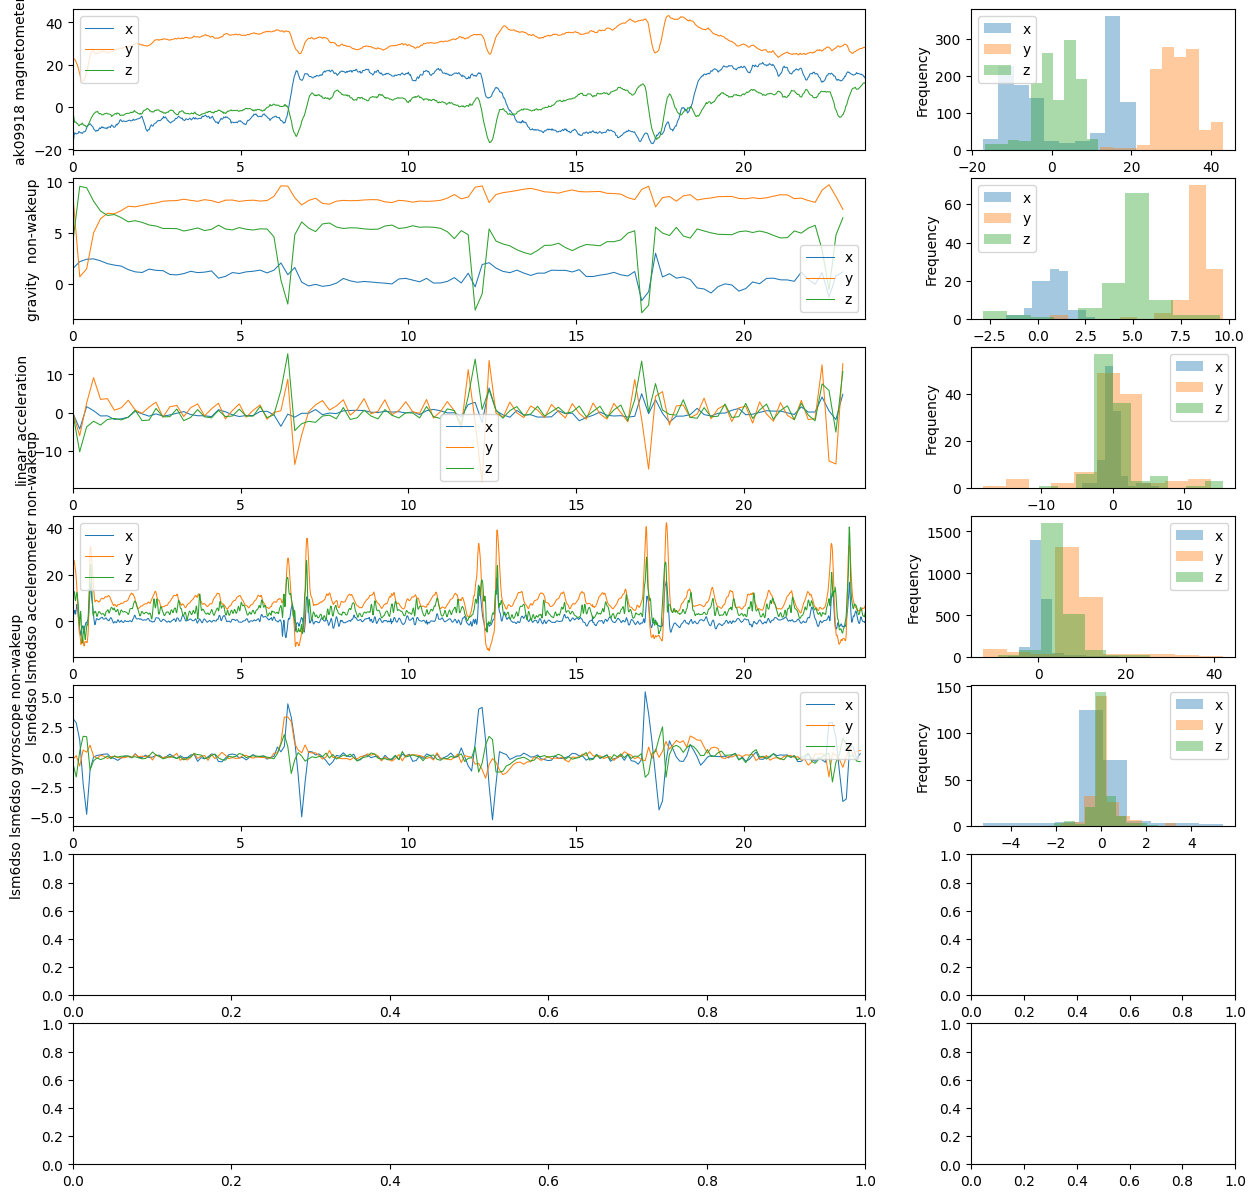

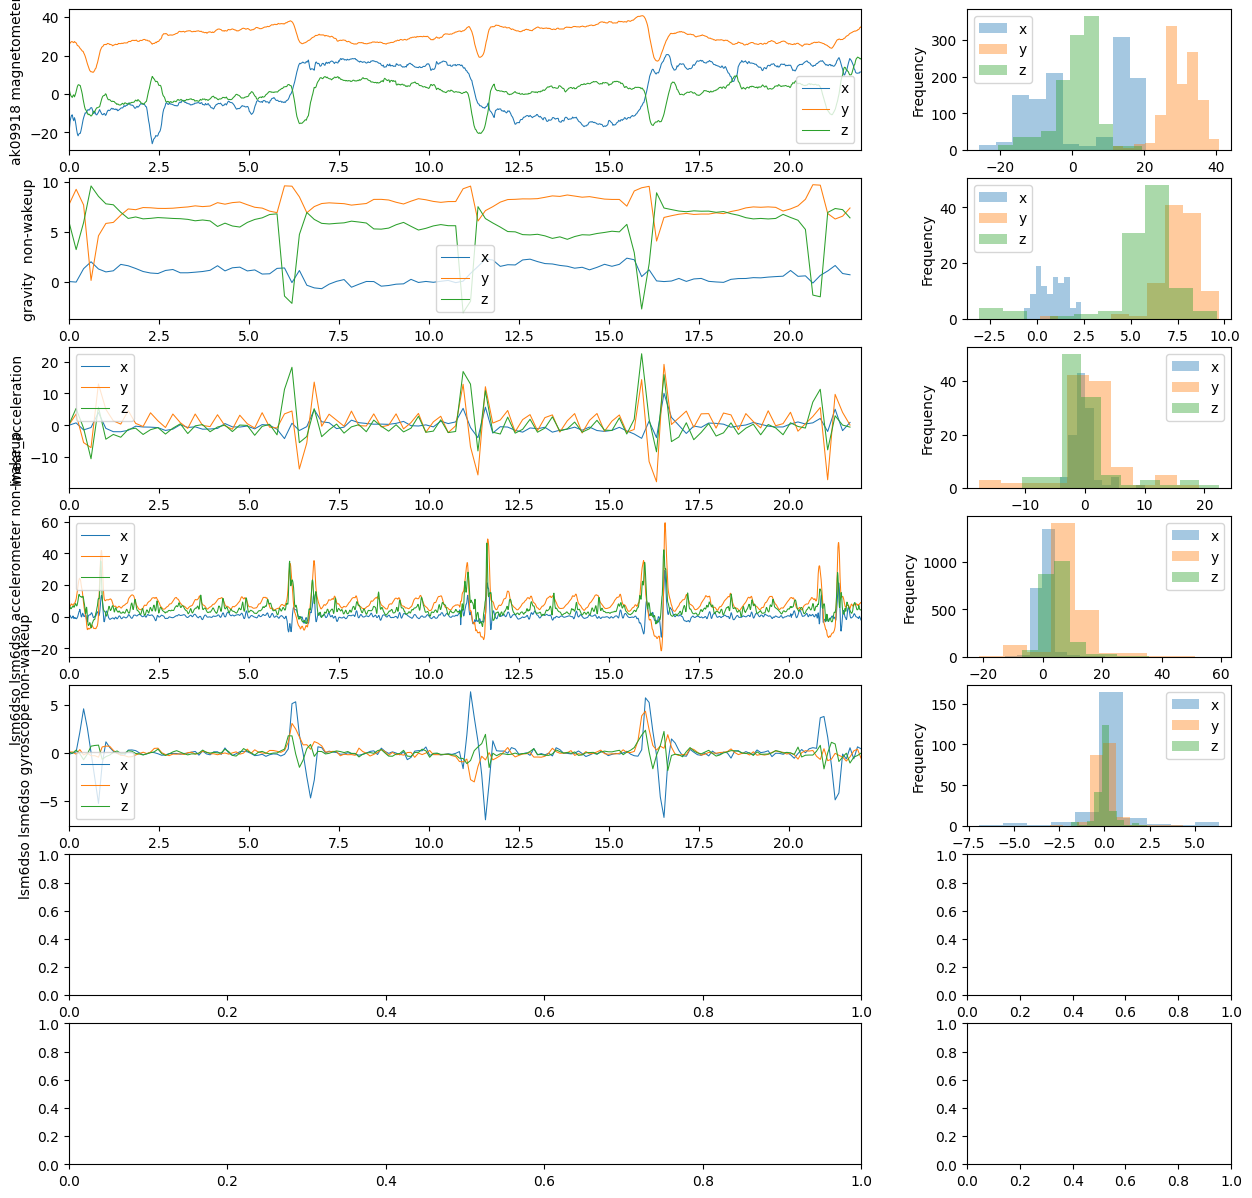

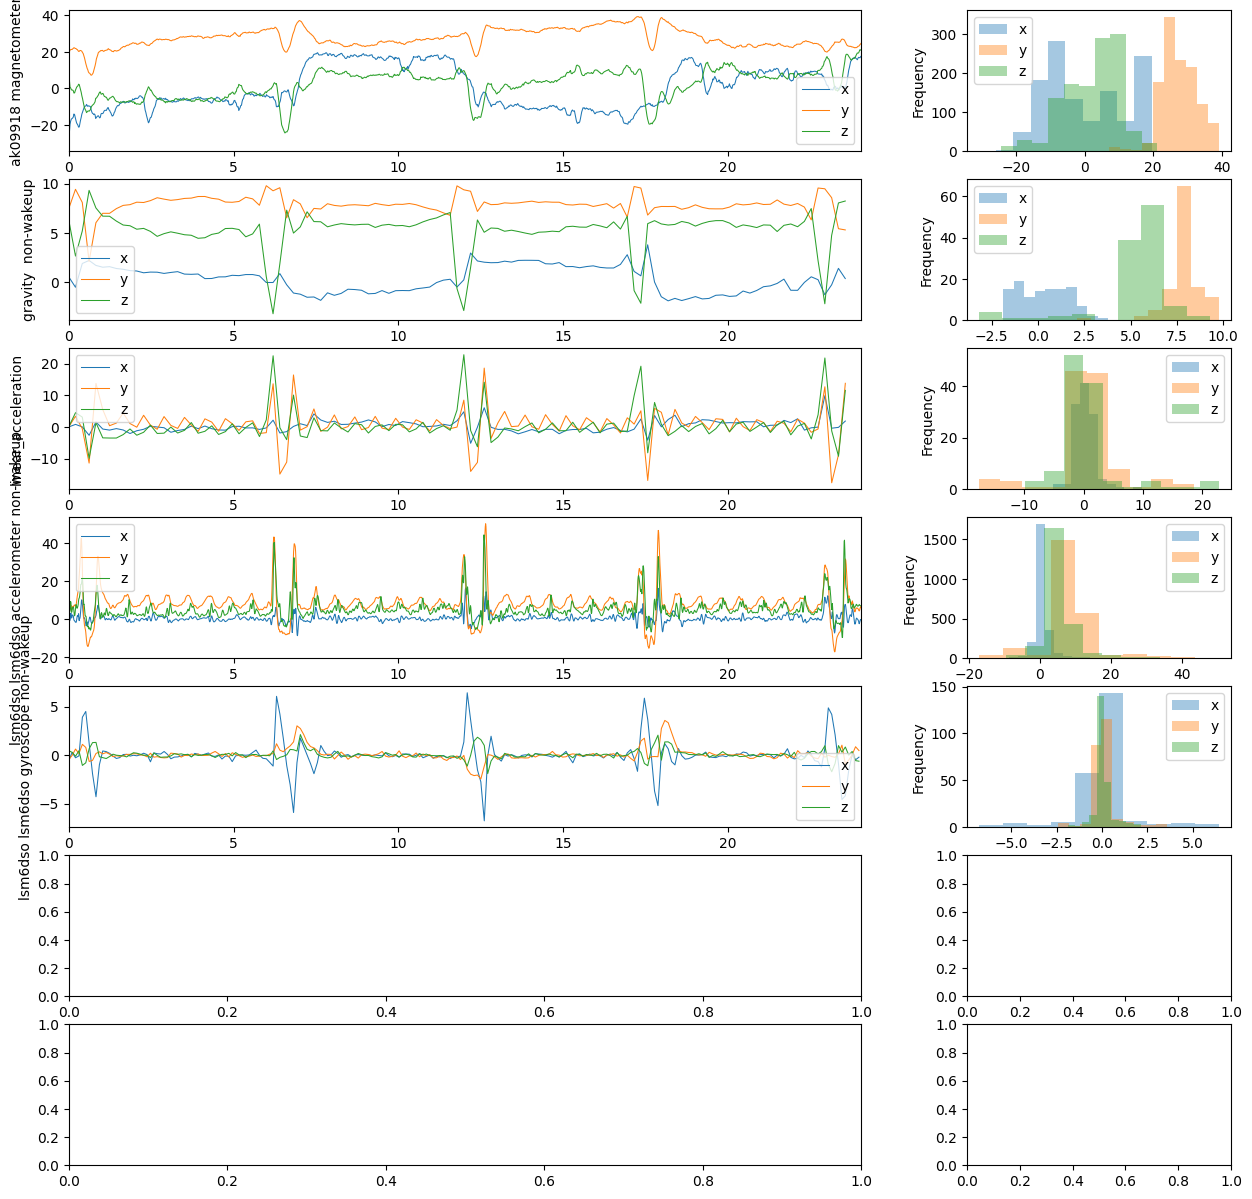

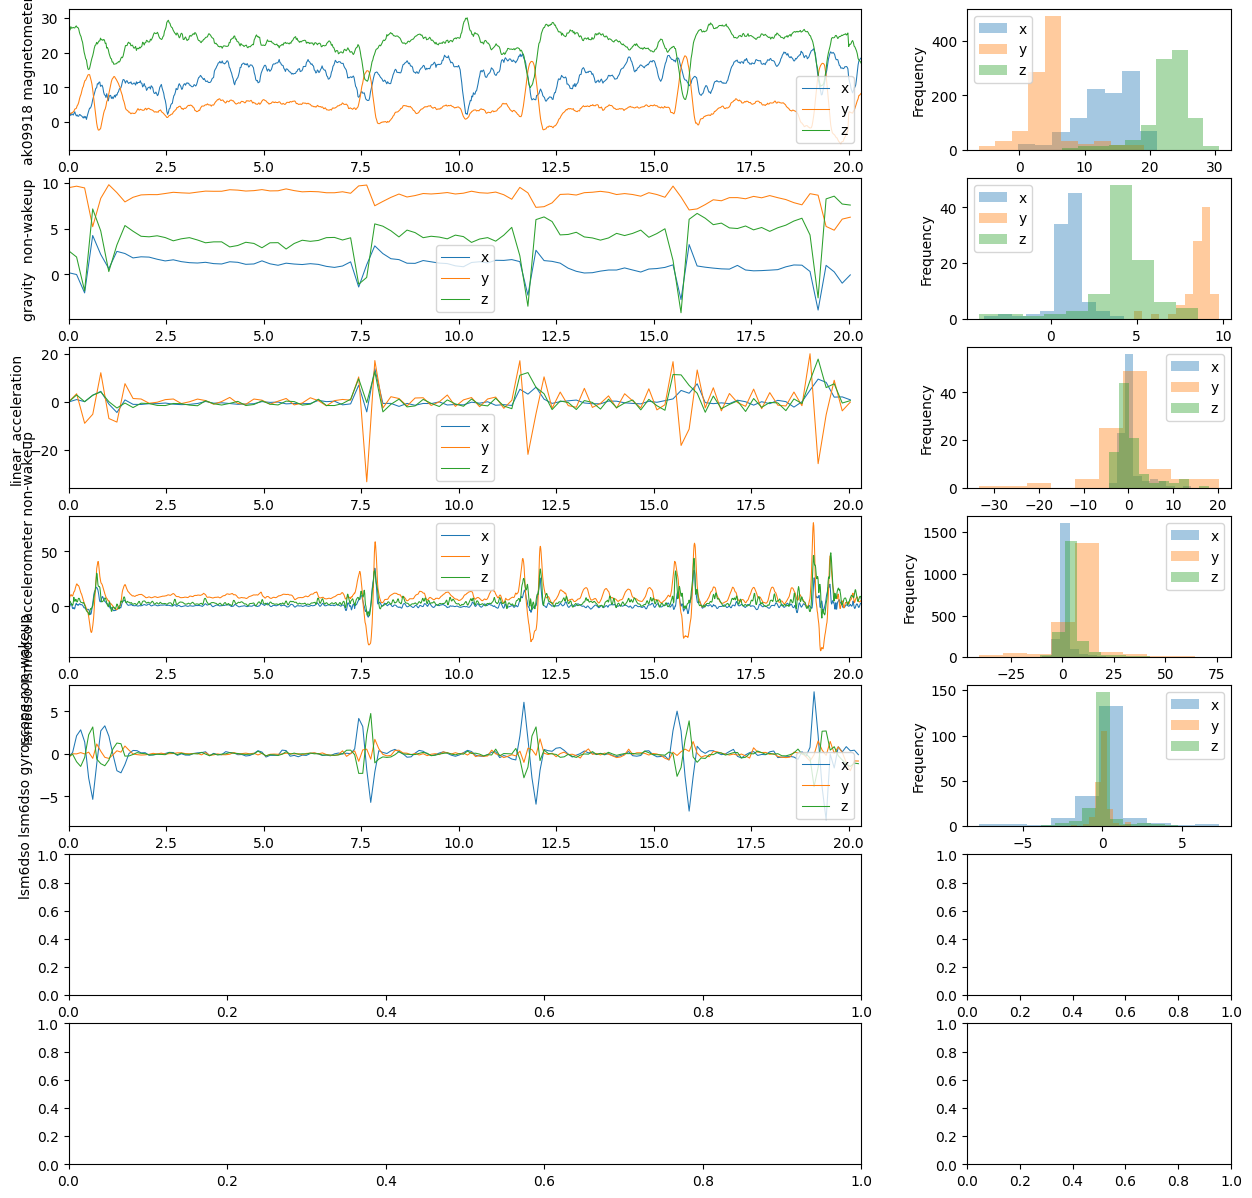

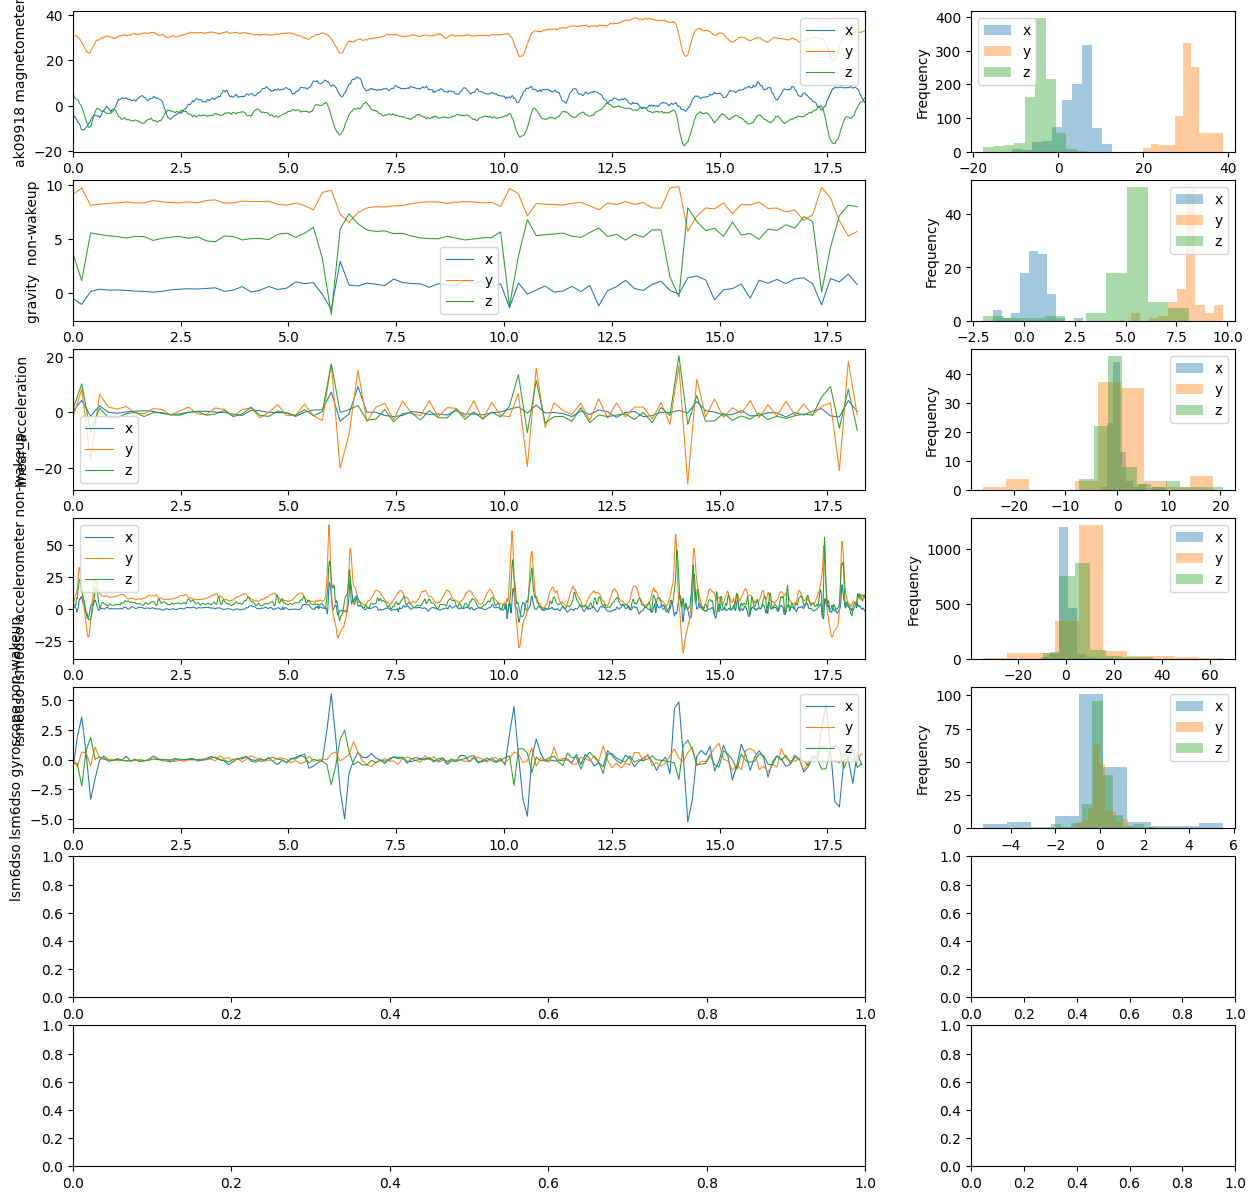

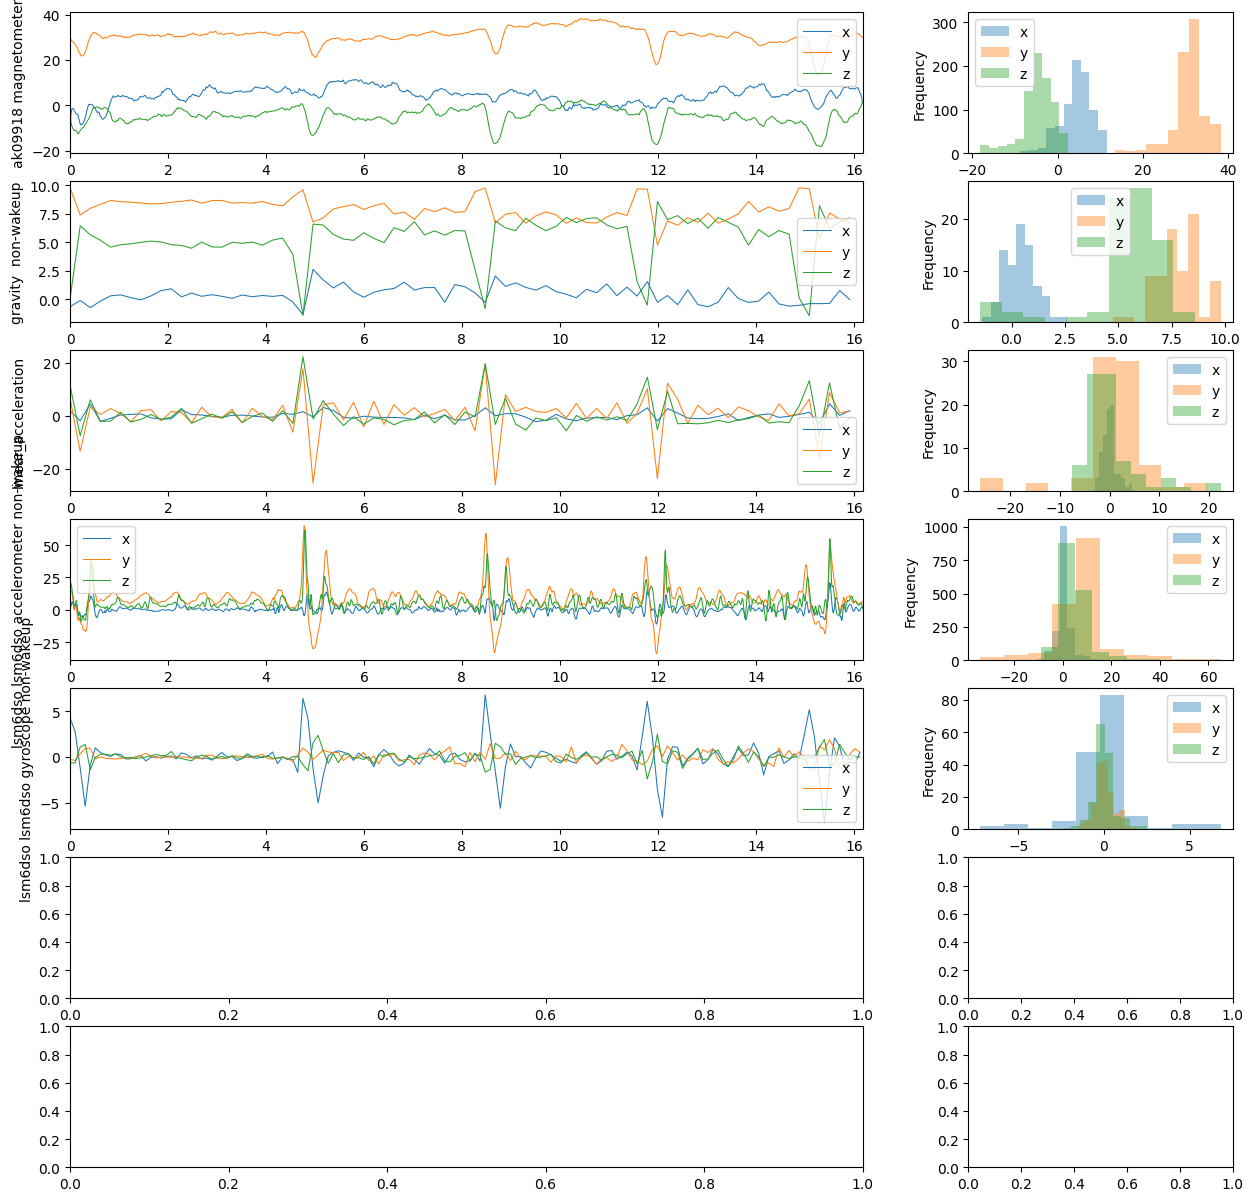

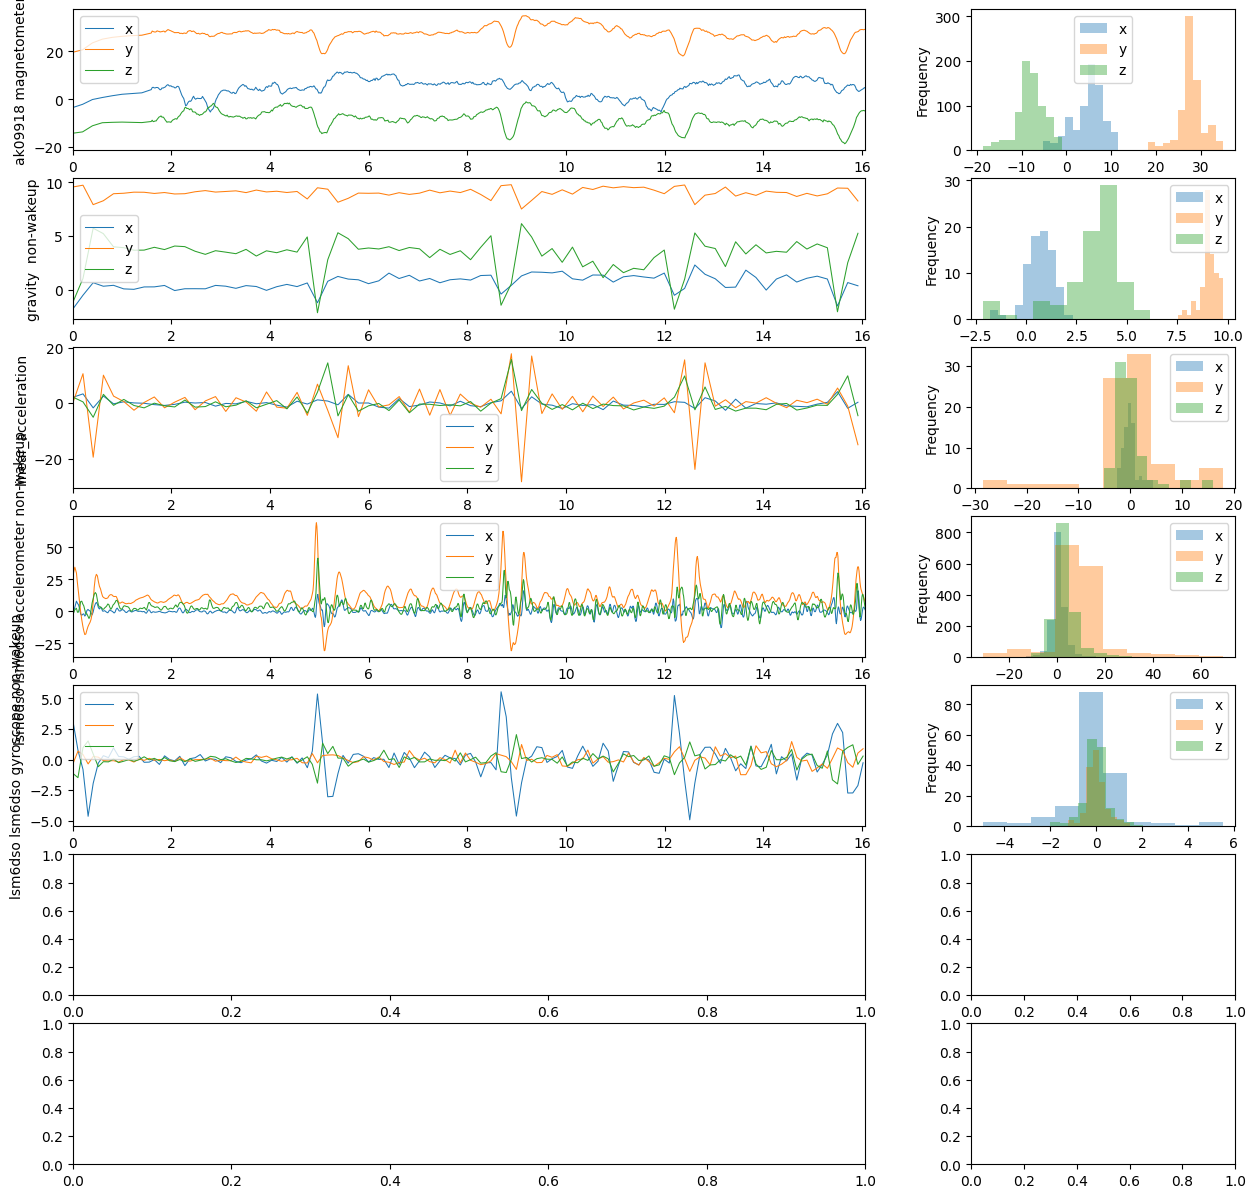

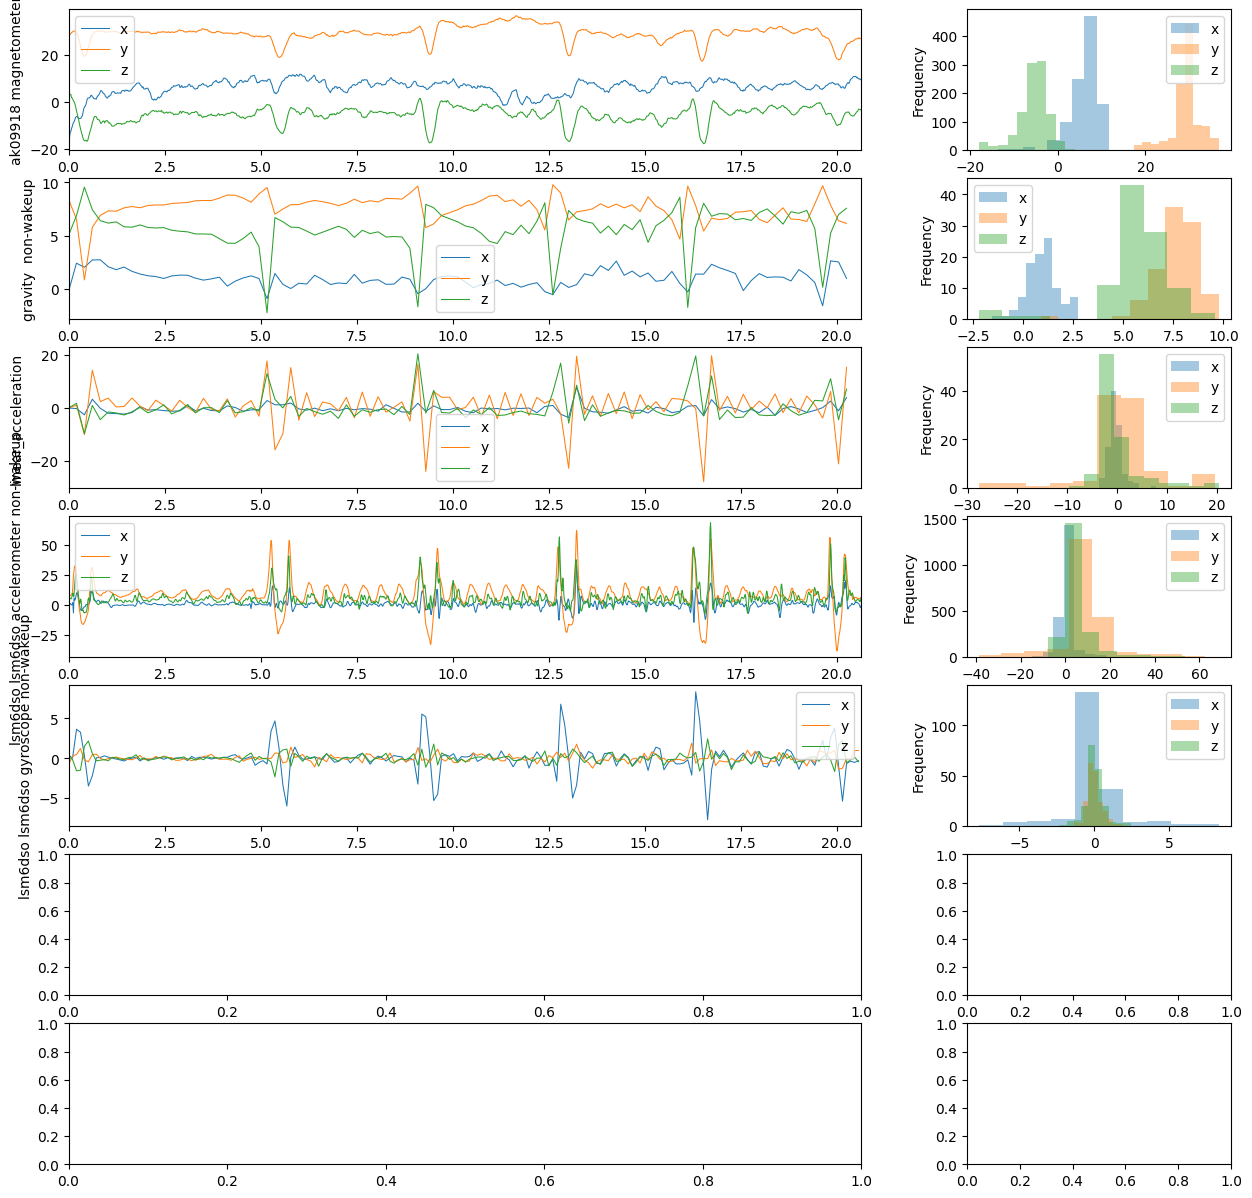

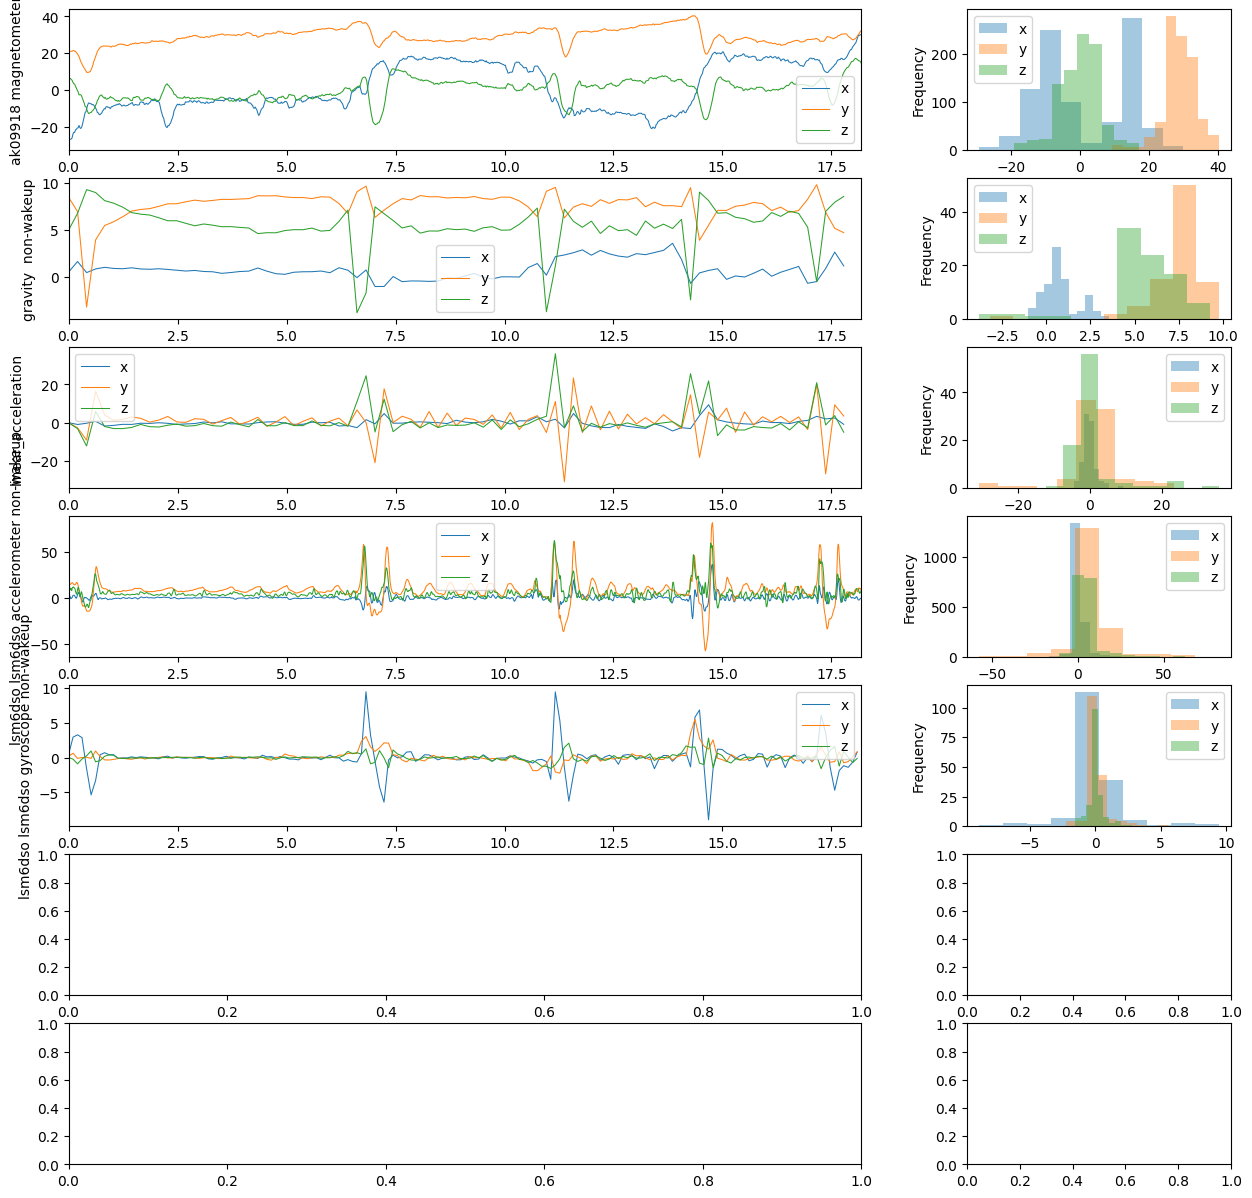

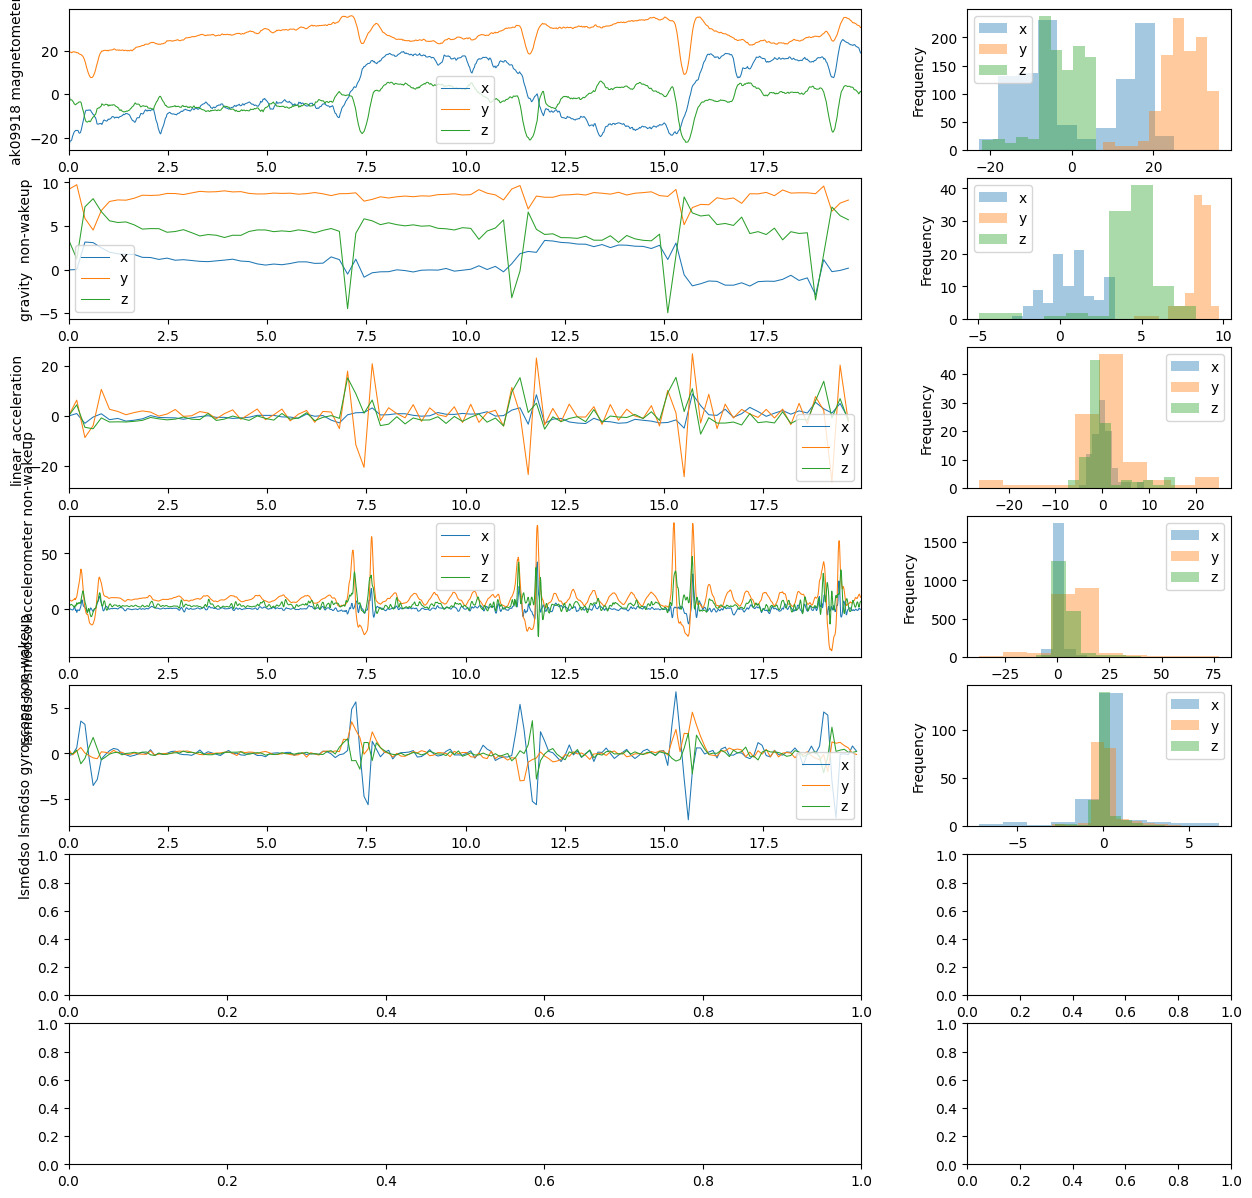

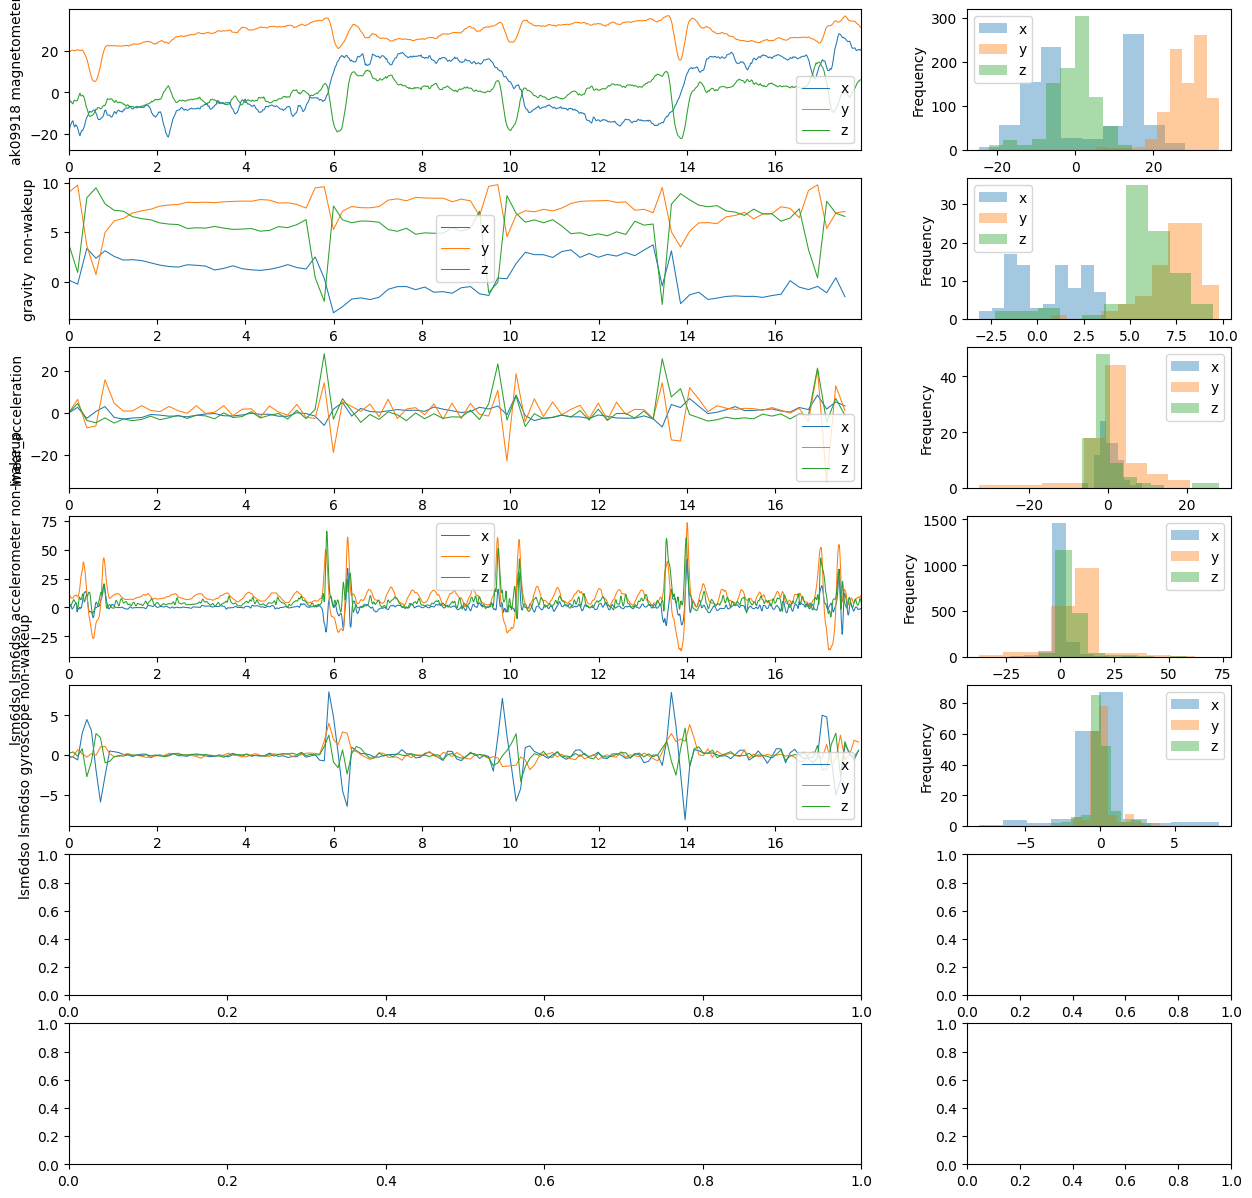

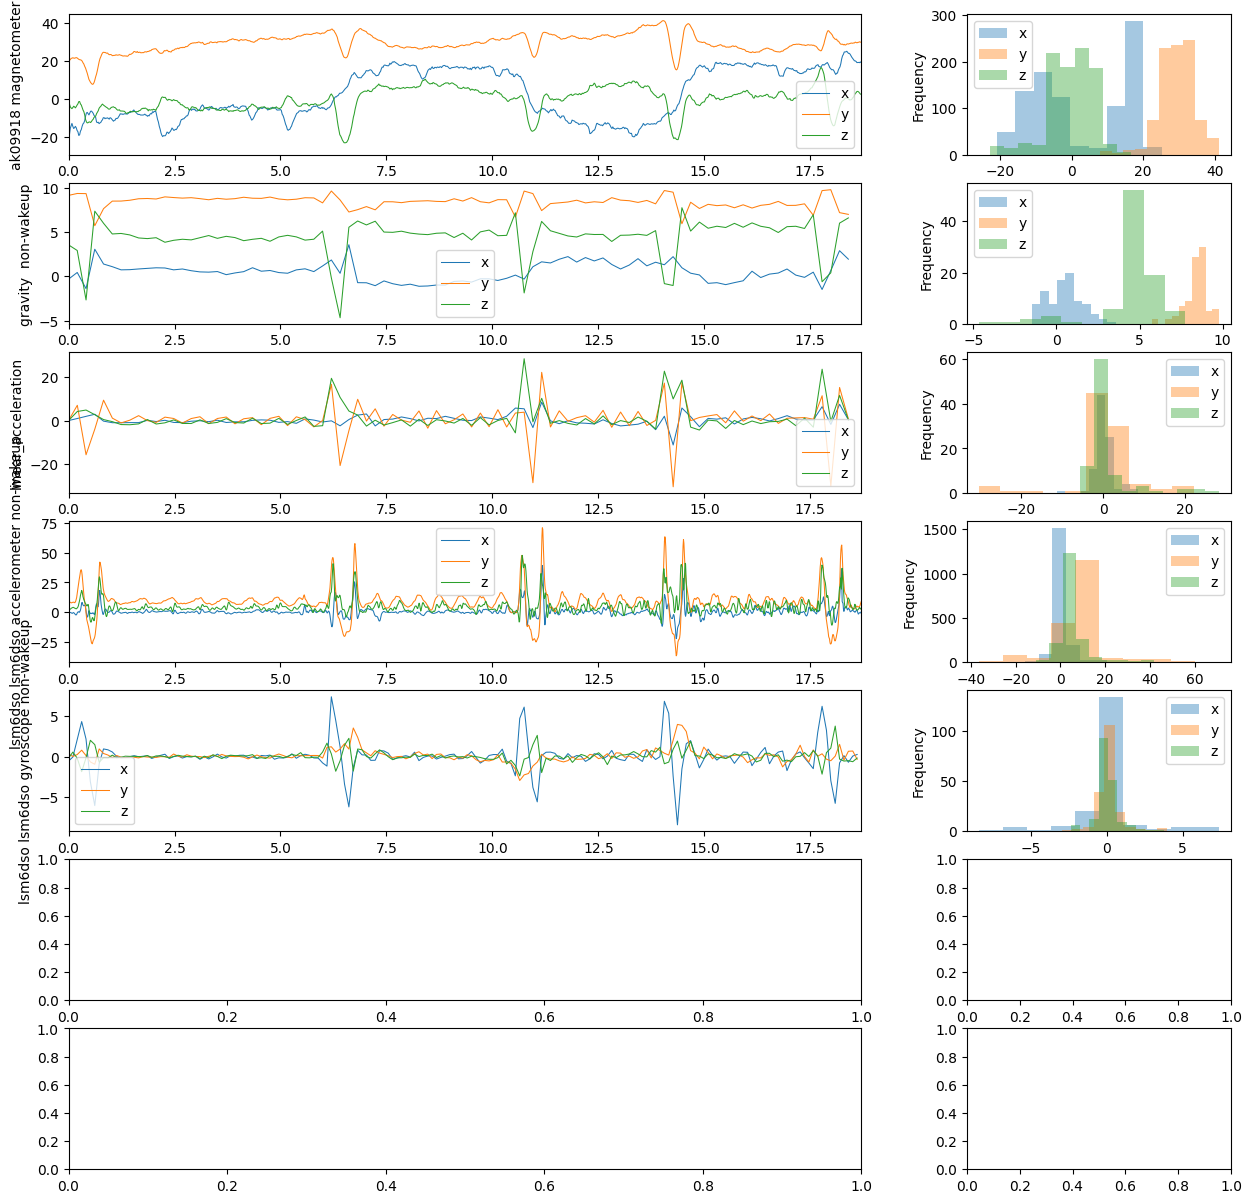

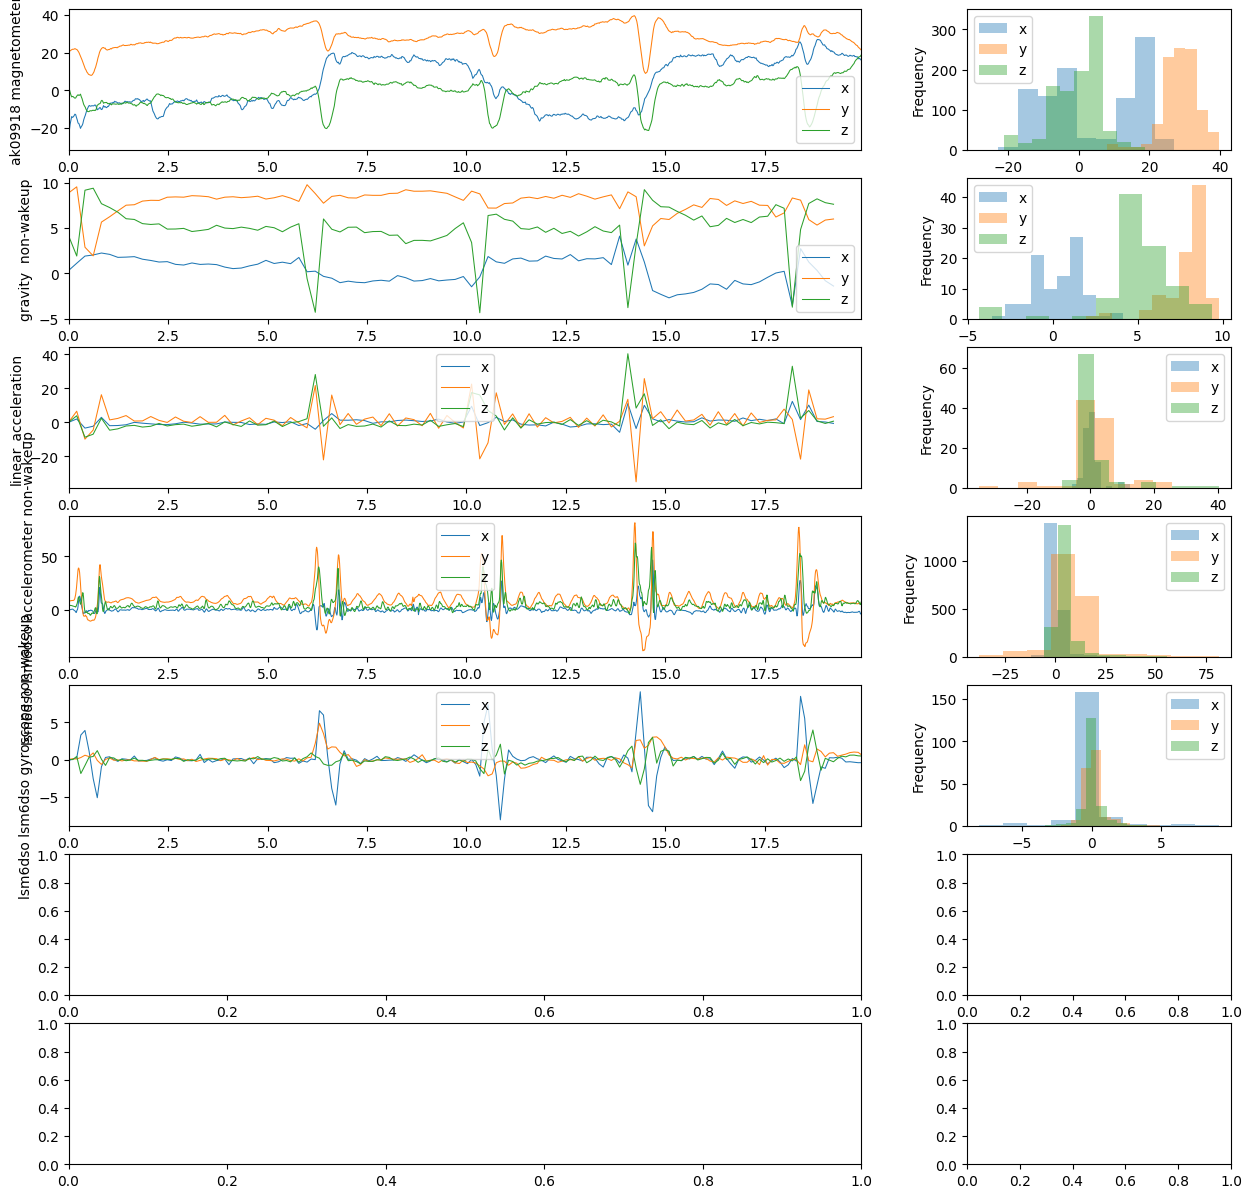

In [ ]:
from sideseeing_tools import sideseeing
from sideseeing_tools import plot
ds = sideseeing.SideSeeingDS(root_dir='/content/drive/MyDrive/Colab_Notebooks/EP2-MAC0209/EP2_EXPERIMENTOS', name='MyDataset')
plotter = plot.SideSeeingPlotter(ds)
ds.sensors
for i in ds.iterator:
  try: plotter.plot_instance_sensors3_and_audio(i)
  except: continue

# Solucão Analítica


In [ ]:
#velocidades medias = array de velocidade média para um tipo de experimento
#aceleracoes medias = ''  ''   aceleracoes ''
def solucao_analitica(velocidades_medias, aceleracoes_medias, experimento):
  x_array = []
  t_array = []
  t_i_array = []
  x = 0
  t = 0
  t_i = 0
  dt = 0.01
  #Uniformemente acelerado, usar aceleracao media
  if experimento[:3] == 'MUA':
    a = np.mean(aceleracoes_medias) + np.random.normal(0, dp)
    dp = np.std(aceleracoes_medias)
    while x <= 32:
      t_array.append(t)
      x_array.append(x)
      x = (a*t**2)/2
      t += dt
      if x >= t_i:
        t_i_array.append(t)
        t_i += 8
    return t_array, x_array, t_i_array

  #Uniforme, velocidade média
  elif experimento[:2] == 'MU':
    v = np.mean(velocidades_medias) + np.random.normal(0, dp)
    dp = np.std(velocidades_medias)
    while x <= 32:
      t_array.append(t)
      x_array.append(x)
      x = v*t
      t += dt
      if x >= t_i:
        t_i_array.append(t)
        t_i += 8
    return t_array, x_array, t_i_array

  else:
    print("Passe um experimento válido")

In [ ]:
experimentos = ['MU-RETA', 'MUA-RETA', 'MU-ZIGZAG', 'MUA-ZIGZAG']
realizacoes_array = []
r = 0

for i in experimentos:
  for j in range(50):
    velocidades_medias = []
    aceleracoes_medias = []
    for k in range(0, 5):
      #velocidades_medias.append(calcular_velocidade_media(experimentos[i]+str(j+1)))
      #aceleracoes_medias.append(calcular_aceleracao_media(experimentos[i]+str(j+1)))
      continue
    t_array, x_array, t_i_array = solucao_analitica(velocidades_medias, aceleracoes_medias, i)
    v = np.mean(velocidades_medias)
    if experimentos[i][:3] == 'MUA':
      a = np.mean(aceleracoes_medias)
      movimento = 'MUA'
    else:
      a = 0
      movimento = 'MU'
    if experimentos[i] == 'MU-RETA' or experimentos[i] == 'MUA-RETA': trajeto = 1
    else: trajeto = 2
    dp_velocidade = np.std(velocidades_medias)
    dp_aceleracao = np.std(aceleracoes_medias)
    realizacoes_array.append({'Amostra': ('r'+str(r)), 't0': t_i_array[0], 't1': t_i_array[1], 't2': t_i_array[2], 't3': t_i_array[3], 't4': t_i_array[4], 'Comprimento': 32, 'Velocidade k': v, 'Aceleracao k': a, 'Trajeto': trajeto})
    r += 1
    #plot t array e x array com nome experimento

df = pd.DataFrame(realizacoes_array)
df.to_csv('realizacoes_analitica.csv', index=False)




# Algorítmo de Euler

In [ ]:
#velocidades medias = array de velocidade média para um tipo de experimento
#aceleracoes medias = ''  ''   aceleracoes ''
def algoritmo_euler(velocidades_medias, aceleracoes_medias, experimento):
  x_array = []
  t_array = []
  t_i_array = []
  x = 0
  t = 0
  t_i = 0
  dt = 0.01
  #Uniformemente acelerado, usar aceleracao media
  if experimento[:3] == 'MUA':
    a = np.mean(aceleracoes_medias)
    dp = np.std(aceleracoes_medias)
    v = 0
    i = 0
    while x <= 32:
      x_array.append(x)
      t_array.append(t)
      x += v*dt
      v += a*dt
      if v < 0: v = 0
      a = a + np.normal(0, dp)
      t += dt
      if x >= t_i:
        t_i_array.append(t)
        t_i += 8
    return t_array, x_array, t_i_array

  #Uniforme, velocidade média
  elif experimento[:2] == 'MU':
    dp = np.std(velocidades_medias)
    while x <= 32:
      x_array.append(x)
      t_array.append(t)
      x += v*dt
      v = v + np.normal(0, dp)
      if v < 0: v = 0
      t += dt
      if x >= t_i:
        t_i_array.append(t)
        t_i += 8
    return t_array, x_array, t_i_array

  else:
    print("Passe um experimento válido")



In [ ]:
#mesmo codigo p plotar